## Signal Prediction


# Introduction

**Problem definition:** given 120 historical timestamps with signal classes, predict change in signal for the next 30 steps ahead.

This model is trained for L249, including signals and requests of buses (public transport).

**Dataset description:**

* Total number of instances: 86400
* Training set: 70%
* Validation set: 20%
* Test set: 10%
* Timestamp - a value representing seconds
* D1, D2, D3, D4 - attribute values
* K1, K2, K3, K4 - target values

Problem settings: predict such tagret virables as **'K01R', 'K02', 'K03'** based on such features as 'timestamp/Uhrzeit' (TX).


*   **BK02**: Bemessung für K02 (Interner Detektor **D21/22**)
*   **ANF_K03**: Anforderung für K03
*   **ZYK**: cycle time

K01R status: R->S->G->A->R (A: Achtung; S: Start; G: Grün; R: Rot), only Green is 1, other status will be set to 0

**Class 1:** green (the vehicle is free to pass the intersection)

**Class 0:** red, yellow, yellow_green (the vehicle must stop)

This notebook consists of the implementation of the following **models**:

* Long short term memory (LSTM)

**trained with only historical data (1 feature), instead of multi-features e.g. sensors, requests. Then draw AUCs for prediction of 1s, 15s, and 30s. Finally, the results will be used to compare with GCN-LSTM trained with the same features.**



# Data Preparation

In [ ]:
# set a target variable 'K1', 'K2', 'K3', 'K4'
trg = 'K1'
# including Bus

In [ ]:
# some APIs are expired, therefore tensorflow needs to be degraded
!pip install tensorflow==2.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 3.6.0
    Uninstalling keras-3.6.0:
      Successfully uninstalled keras-3.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
  

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
from tensorflow.keras import layers
import keras.optimizers
mpl.style.use('bmh')

mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False

# for downloading a file from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading data from google drive

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/249/2021-12-14-L0249(processed).CSV', low_memory=False)

df=df.drop(columns=['Uhrzeit'])
df

,K1,K2,K3,K4,S1,S1T,S2,S3,F1,FR2,...,MPN_15956,MPN_15957,MPN_15940,MPN_15941,MPN_4,MPN_5,MPN_6,MPN_1,MPN_2,MPN_3
0,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
1,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
2,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
3,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
4,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86396,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86397,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86398,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0


## Data Transform

In [ ]:

# add time frame (as index)
df['timestamp'] = df.index
col_name="timestamp"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)

# re-transforming the problem to binary classification
# red, yellow and yellow_red attibutes = 0, green = 1

df.replace('G', '1', inplace=True, regex=True)
df.replace('R', '0', inplace=True, regex=True)
df.replace('A', '0', inplace=True, regex=True)
# acoustic signal for Blinde Lampe
df.replace('a', '1', inplace=True, regex=True)
df.replace('S', '0', inplace=True, regex=True)
df.replace('D', '0', inplace=True, regex=True)

df['AF1'][df.AF1>0]=1
df['AFBT2'][df.AFBT2>0]=1
df['AFBT03'][df.AFBT03>0]=1
df['AFBT01'][df.AFBT01>0]=1
df['AFBT04'][df.AFBT04>0]=1
df['AFK03'][df.AFK03>0]=1
df['AFK02'][df.AFK02>0]=1

df = df.astype(int)

init_df = df
df

<ipython-input-5-fb97a27c59da>:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['AF1'][df.AF1>0]=1
<ipython-input-5-fb97a27c59da>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

,timestamp,K1,K2,K3,K4,S1,S1T,S2,S3,F1,...,MPN_15956,MPN_15957,MPN_15940,MPN_15941,MPN_4,MPN_5,MPN_6,MPN_1,MPN_2,MPN_3
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,86395,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,86396,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,86397,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,86398,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# set target variable

df_k1 = df[['K1','K2','K3','K4','S1','S2','S3','F1','FR2','F3','F4']]

# all 0 column
# BK4, tanK20, tanK30, MPN_15964, MPN_15965, MPN_15956, MPN_15957
# S3, F3, F4

# trg = 'K1'
df_k1['target'] = df[trg]
date_time = pd.to_datetime(df.pop('timestamp'))

df = df_k1

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
test_df

<ipython-input-6-548b18a344a2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k1['target'] = df[trg]


,K1,K2,K3,K4,S1,S2,S3,F1,FR2,F3,F4,target
77760,1,0,0,1,0,0,0,0,1,0,0,1
77761,1,0,0,1,0,0,0,0,1,0,0,1
77762,1,0,0,1,0,0,0,0,1,0,0,1
77763,1,0,0,1,0,0,0,0,1,0,0,1
77764,1,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
86395,1,0,0,1,0,0,0,0,1,0,0,1
86396,1,0,0,1,0,0,0,0,1,0,0,1
86397,1,0,0,1,0,0,0,0,1,0,0,1
86398,1,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
K1,86400.0,0.787593,0.409014,0.0,1.0,1.0,1.0,1.0
K2,86400.0,0.035139,0.184132,0.0,0.0,0.0,0.0,1.0
K3,86400.0,0.084317,0.277864,0.0,0.0,0.0,0.0,1.0
K4,86400.0,0.595208,0.490855,0.0,0.0,1.0,1.0,1.0
S1,86400.0,0.027940,0.164801,0.0,0.0,0.0,0.0,1.0
S2,86400.0,0.023762,0.152306,0.0,0.0,0.0,0.0,1.0
S3,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
F1,86400.0,0.090984,0.287588,0.0,0.0,0.0,0.0,1.0
FR2,86400.0,0.680069,0.466452,0.0,0.0,1.0,1.0,1.0
F3,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


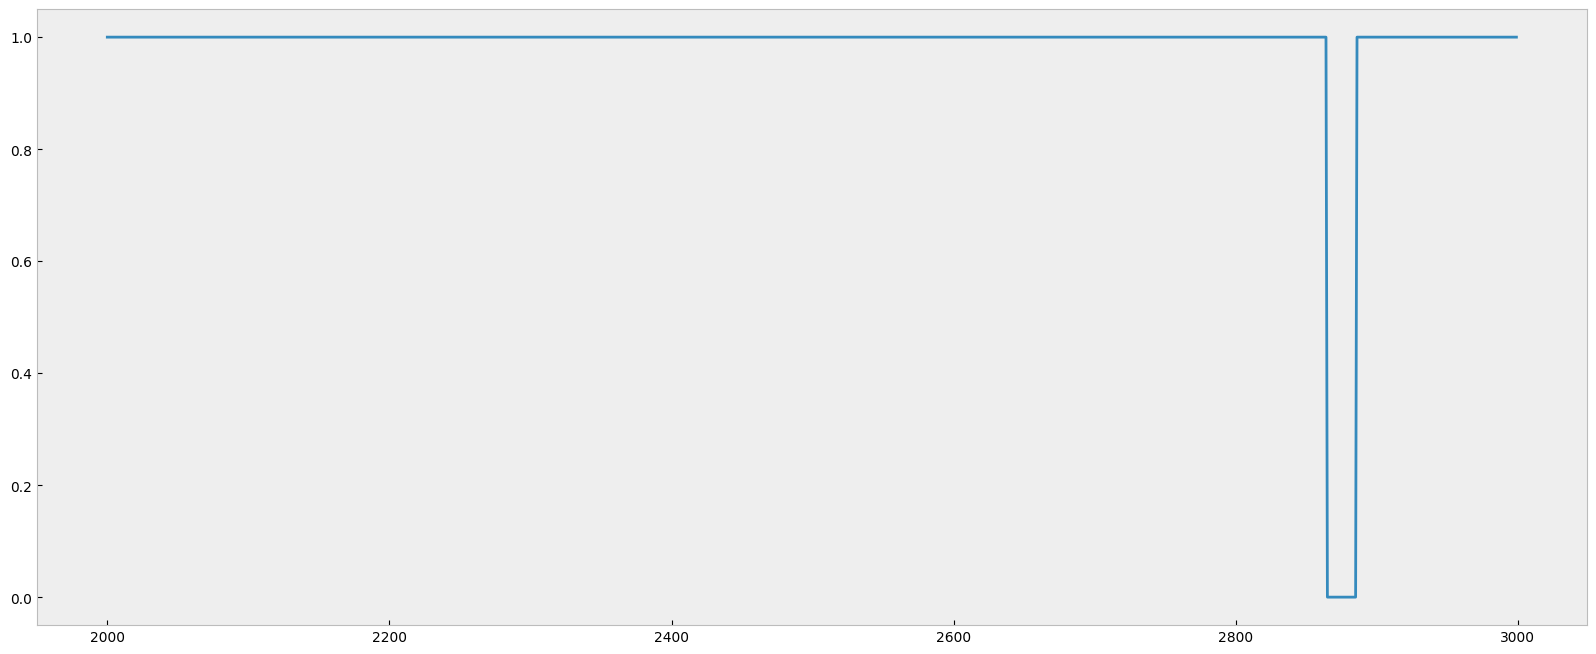

In [ ]:
plt.plot(train_df['target'][2000:3000])

<ipython-input-8-852de4771734>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


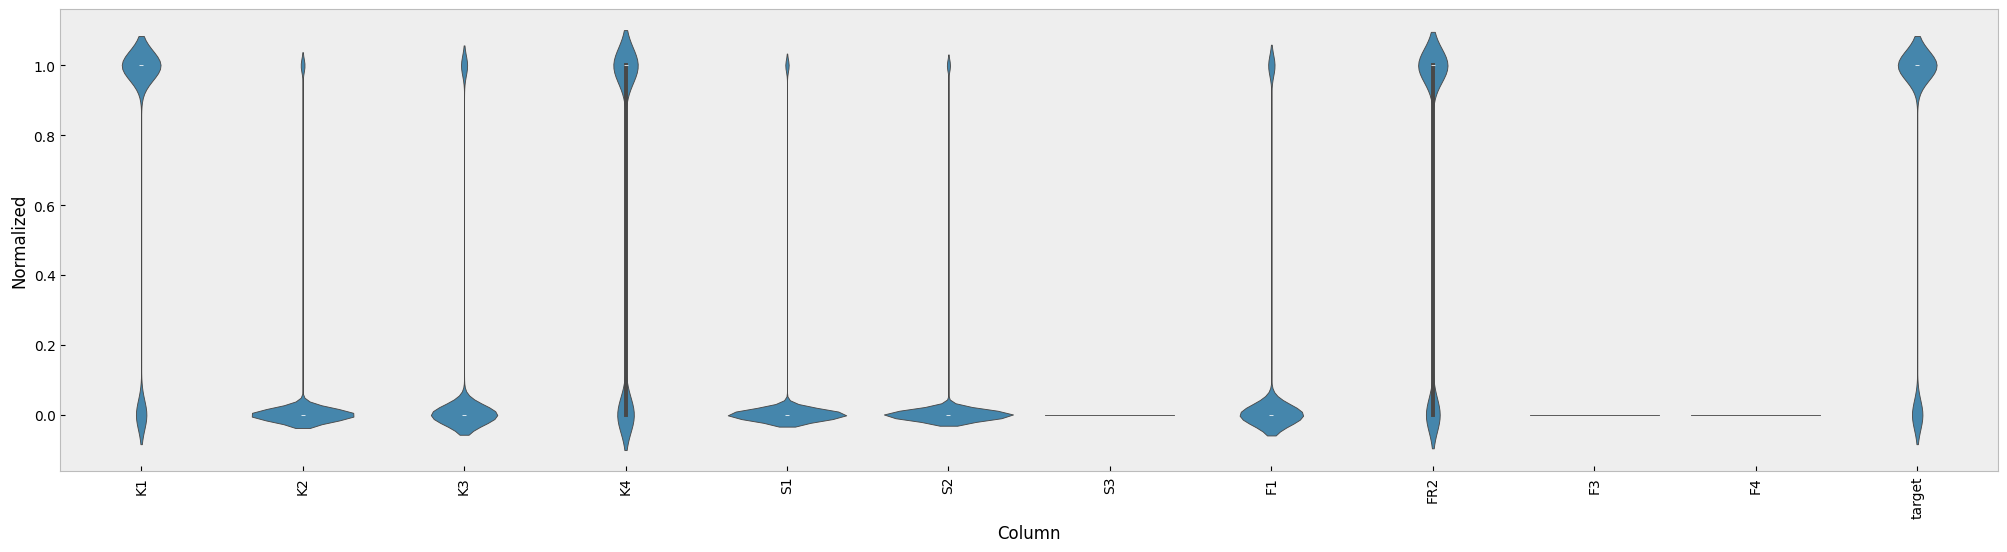

In [ ]:
# plot features before Normalization
df_1 = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(25, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_1)
_ = ax.set_xticklabels(df.keys(), rotation=90)

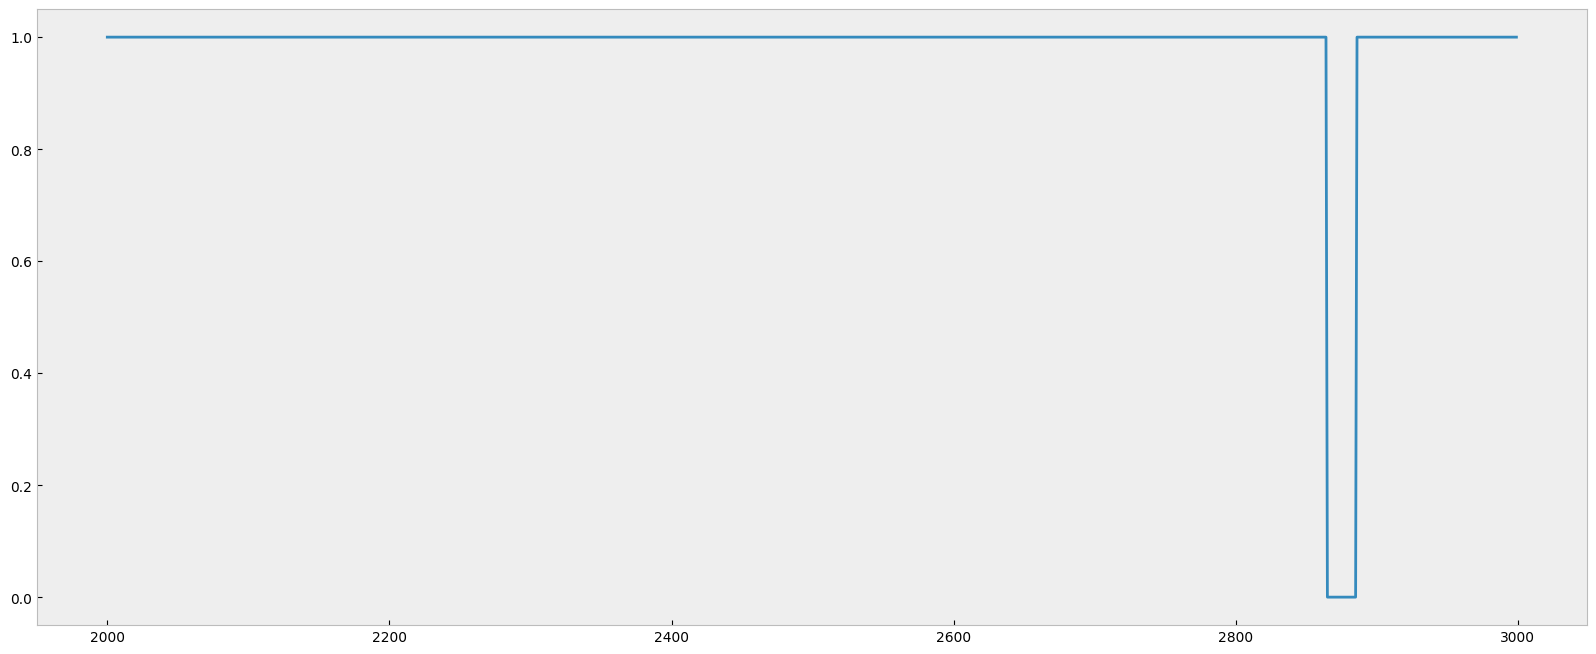

In [ ]:
plt.plot(train_df['target'][2000:3000])

## Time Window Generation

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        #f'Label column name(s): {self.label_columns}'
        ])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='target', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 6))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    marker='o', edgecolors='face', label='Labels', c='#4e8f18', s=84)
        if model is not None:
            # predictions = model.predict(inputs)
            # print(predictions)
            predictions = (model.predict(inputs) > 0.5).astype("int32")
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='*', edgecolors='face', label='Predictions',
                      c='#d1d41c', s=130)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 32
# patience = 5
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                    patience=patience,
                                                    mode='max')

  model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.metrics.BinaryAccuracy()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

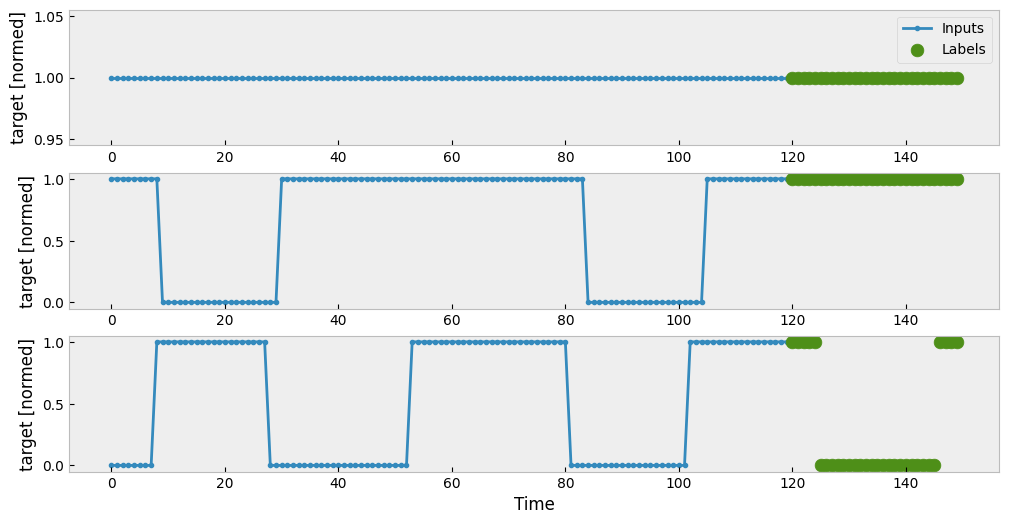

In [ ]:
OUT_STEPS = 30
input_width= 120
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# Machine Learning Training

In [ ]:
multi_val_performance = {}
multi_performance = {}

## Dense Model

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=input_width, activation='relu'),

    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])

])

In [ ]:
history = compile_and_fit(multi_step_dense, multi_window)

# after trainig, save the model for future use
multi_step_dense.save('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/dense_model_1Day_1Feature')

IPython.display.clear_output()

multi_val_performance['Dense'] = multi_step_dense.evaluate(multi_window.val)
multi_performance['Dense'] = multi_step_dense.evaluate(multi_window.test, verbose=0)

536/536 [==============================] - 1s 3ms/step - loss: 0.6583 - binary_accuracy: 0.8832


1/1 [==============================] - 0s 19ms/step


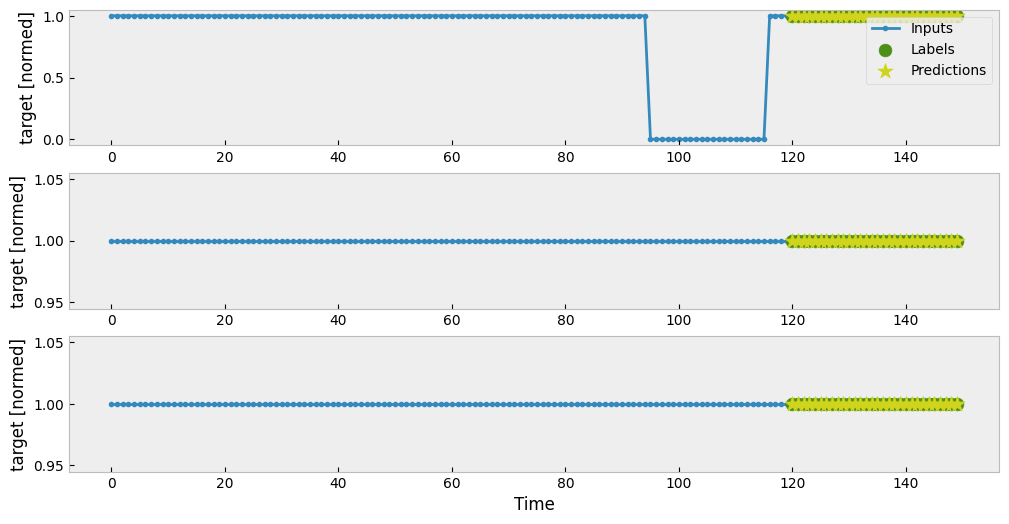

In [ ]:
multi_window.plot(multi_step_dense)

## Last Baseline Model

1/1 [==============================] - 0s 12ms/step


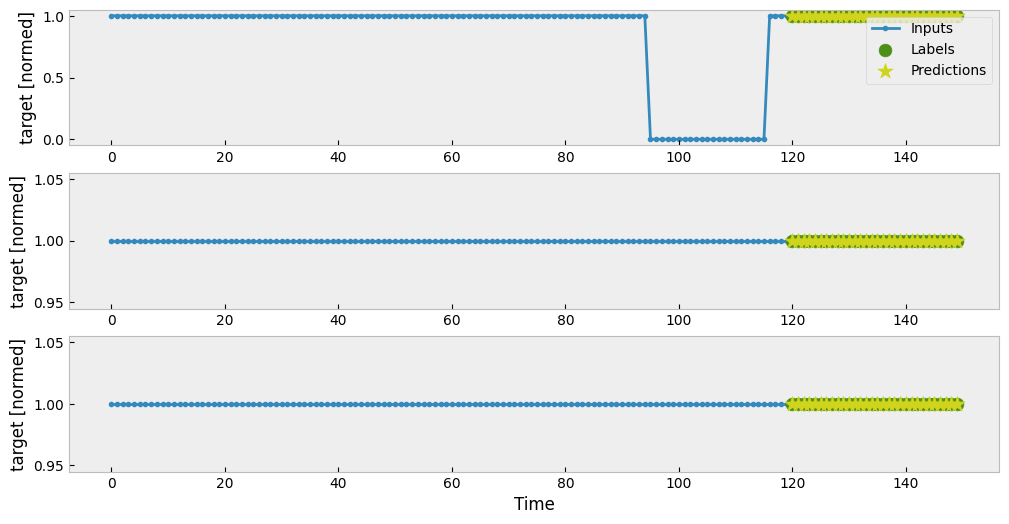

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(#optimizer=tf.optimizers.Adam(),
                      loss= tf.losses.BinaryCrossentropy(from_logits=True),
                      metrics=[tf.metrics.BinaryAccuracy()]
                      )
last_baseline.fit(multi_window.train, epochs=1,
          validation_data=multi_window.val)
# after trainig, save the model
last_baseline.save('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/baseline_model_1Day_1Feature')

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

## Linear Model

1/1 [==============================] - 0s 15ms/step


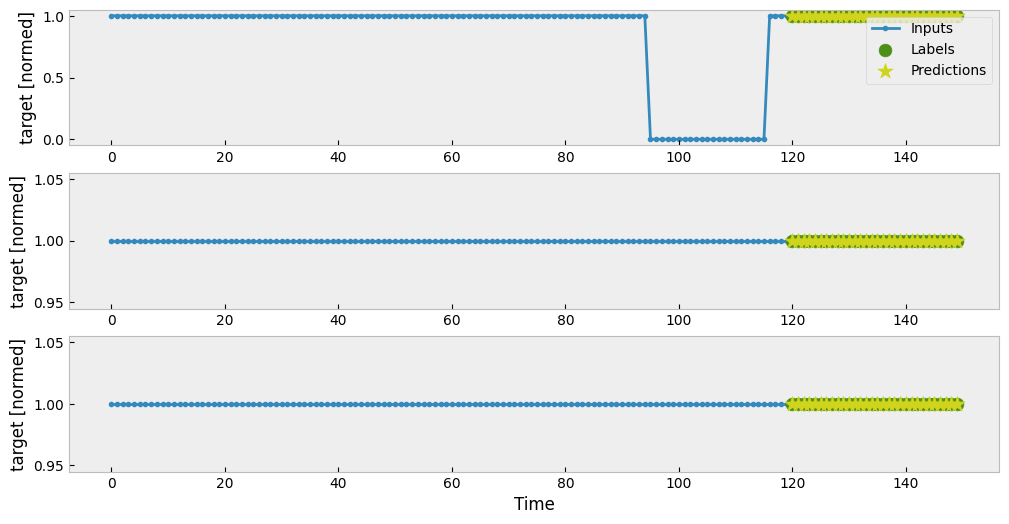

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros , activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
# after trainig, save the model
multi_linear_model.save('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/linear_model_1Day_1Feature')
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## CNN Model

1/1 [==============================] - 0s 14ms/step


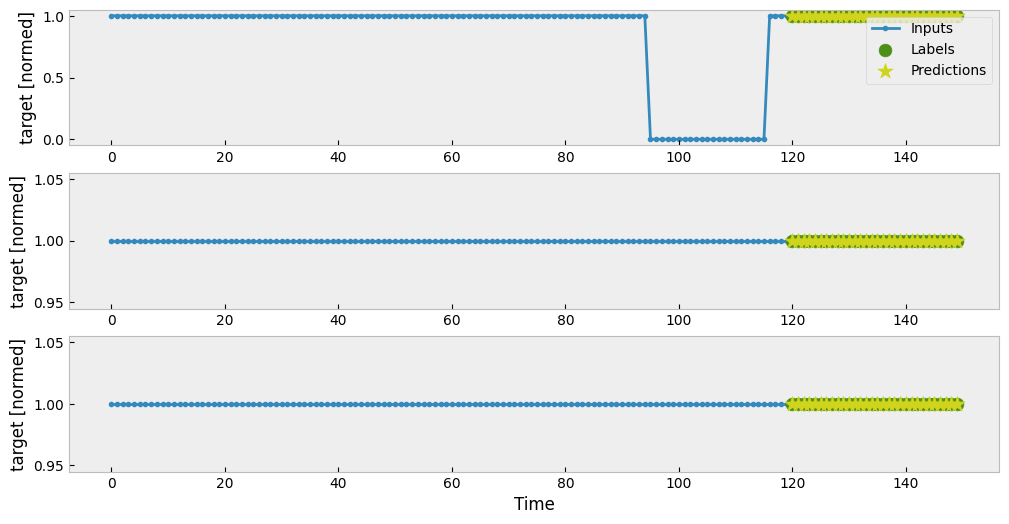

In [ ]:
# CNN

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(120, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros, activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
# after trainig, save the model
multi_conv_model.save('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/cnn_model_1Day_1Feature')
IPython.display.clear_output()

multi_val_performance['CNN'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## LSTM (RNN Model)

1/1 [==============================] - 0s 31ms/step


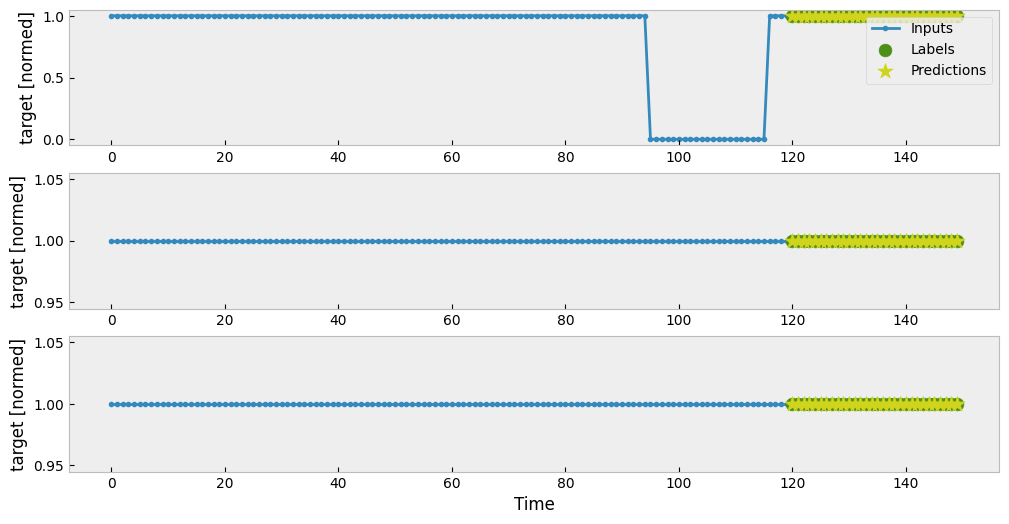

In [ ]:
# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(120, return_sequences=False, activation='tanh'), #tanh
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros() , activation='sigmoid'), #sigmoid
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)
# after training, save the model
multi_lstm_model.save('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/lstm_model_1Day_1Feature')
IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## AR-LSTM

Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=None)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  # the last column is "target column"
  return predictions

FeedBack.call = call

In [ ]:
feedback_model = FeedBack(units=120, out_steps=OUT_STEPS)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 30, 12)


1/1 [==============================] - 0s 76ms/step


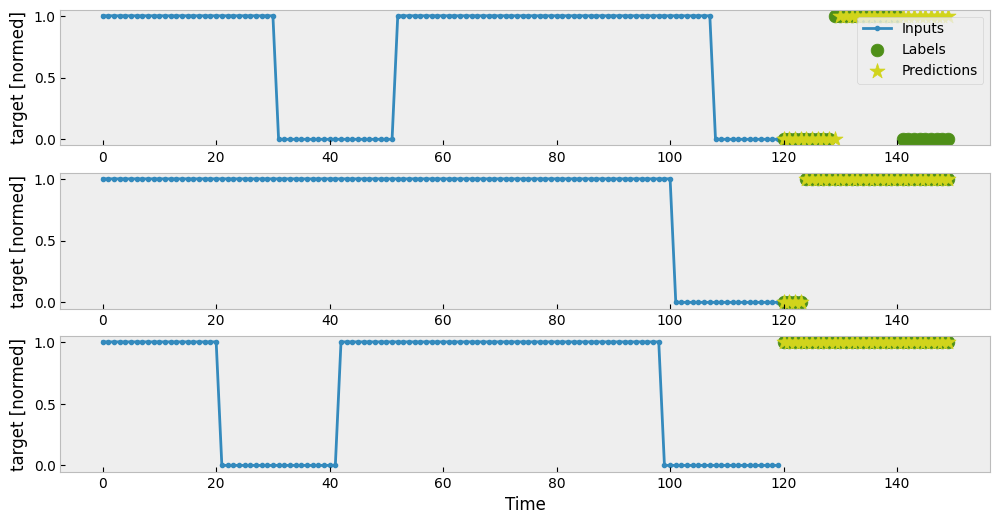

In [ ]:
history = compile_and_fit(feedback_model, multi_window)
# after training, save the model
feedback_model.save('/content/drive/MyDrive/Colab Notebooks/249/models/ar_lstm_model_1Day_1Feature')
IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
print("", multi_performance)
print("validation accuracy: ",multi_val_performance)

 {'AR LSTM': [0.13262973725795746, 0.943168580532074]}
validation accuracy:  {'AR LSTM': [0.20765791833400726, 0.90030837059021]}


## Performance


### Binary Accuracy

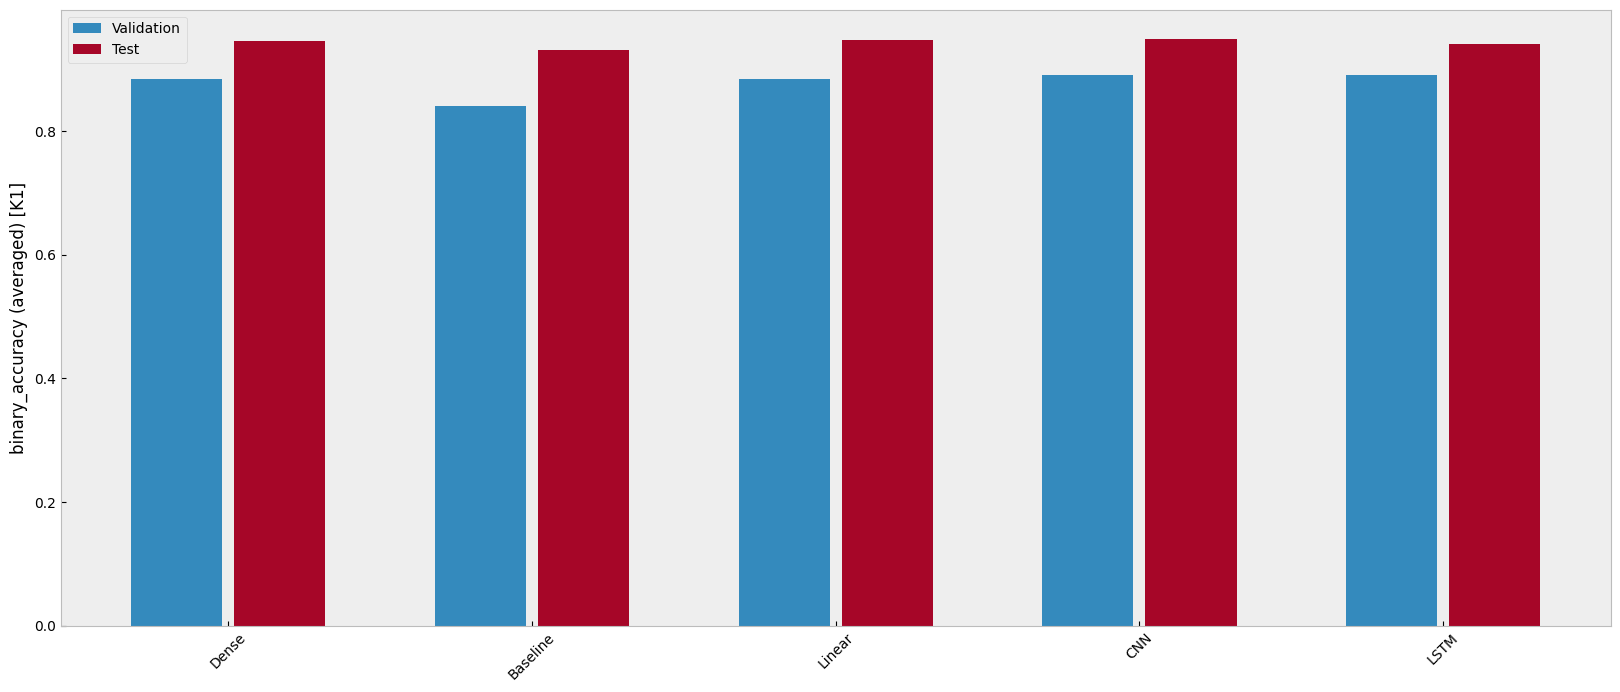

In [ ]:
# performance

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'binary_accuracy'
metric_index = multi_lstm_model.metrics_names.index('binary_accuracy')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'binary_accuracy (averaged) ' + '['+ trg + ']')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Dense   : 0.9457
Baseline: 0.9314
Linear  : 0.9464
CNN     : 0.9487
LSTM    : 0.9406


In [ ]:
print(multi_performance)

{'Dense': [0.6075562834739685, 0.9456519484519958], 'Baseline': [0.6150898933410645, 0.9314234852790833], 'Linear': [0.6077706217765808, 0.9463984966278076], 'CNN': [0.6061217784881592, 0.9486969709396362], 'LSTM': [0.6079883575439453, 0.9406378269195557]}


In [ ]:
for name, value in multi_val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Dense   : 0.8832
Baseline: 0.8408
Linear  : 0.8835
CNN     : 0.8902
LSTM    : 0.8909


### Basic Metrics
所有训练好的模型已经保存，不需要重复运行训练，只需要加载即可，此部分和训练部分代码可分开运行。

In [ ]:
print('iter: ', len(list(multi_window.test)))

iter:  266


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics
CONV_WIDTH = 3 #for cnn model
# load models
#keras.layers.TFSMLayer(/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/dense_model_1Day_1Feature, call_endpoint='serving_default')
dense_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/dense_model_1Day_1Feature')
baseline_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/baseline_model_1Day_1Feature')
linear_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/linear_model_1Day_1Feature')
cnn_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/cnn_model_1Day_1Feature')
lstm_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/lstm_model_1Day_1Feature')
ar_lstm_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/ar_lstm_model_1Day_1Feature')
#ar_lstm_model_1D = feedback_model

# initiation
y_tests = []

predictions_dense = []
predictions_baseline = []
predictions_linear = []
predictions_cnn = []
predictions_lstm = []
predictions_ar_lstm = []

y_probas_lstm = []
y_probas_dense = []
y_probas_baseline = []
y_probas_linear = []
y_probas_cnn = []
y_probas_ar_lstm =[]

i = 0
it = iter(multi_window.test)

# batchsize(32)*266 +120 = 8632

for i in range(266): #266
        # obtain the next value:
        result = next(it)
        inputs, labels = result
        #batchsize,
        y_test = labels[0, :, multi_window.column_indices['target']]
        y_tests.extend(y_test)

        # -1- Dense Model
        # dense-predictions (binary int)
        prediction_dense = (dense_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_dense.extend(prediction_dense[0, :, multi_window.column_indices['target']])
        # dense-proba (float probability)
        y_proba_dense = dense_model_1D.predict(inputs)
        y_probas_dense.extend(y_proba_dense[0, :, multi_window.column_indices['target']])

        # -2- Baseline Model
        # baseline-predictions (binary int)
        prediction_baseline = (baseline_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_baseline.extend(prediction_baseline[0, :, multi_window.column_indices['target']])
        # baseline-proba (float probability)
        y_proba_baseline = baseline_model_1D.predict(inputs)
        y_probas_baseline.extend(y_proba_baseline[0, :, multi_window.column_indices['target']])

        # -3- Linear Model
        # linear-predictions (binary int)
        prediction_linear = (linear_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_linear.extend(prediction_linear[0, :, multi_window.column_indices['target']])
        # linear-proba (float probability)
        y_proba_linear = linear_model_1D.predict(inputs)
        y_probas_linear.extend(y_proba_linear[0, :, multi_window.column_indices['target']])

        # -4- CNN Model
        # cnn-predictions (binary int)
        prediction_cnn = (cnn_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_cnn.extend(prediction_cnn[0, :, multi_window.column_indices['target']])
        # cnn-proba (float probability)
        y_proba_cnn = cnn_model_1D.predict(inputs)
        y_probas_cnn.extend(y_proba_cnn[0, :, multi_window.column_indices['target']])

        # -5- LSTM
        # LSTM-predictions (binary int)
        prediction_lstm = (lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_lstm.extend(prediction_lstm[0, :, multi_window.column_indices['target']])
        # LSTM-proba (float probability)
        y_proba_lstm = lstm_model_1D.predict(inputs)
        y_probas_lstm.extend(y_proba_lstm[0, :, multi_window.column_indices['target']])


        # -6- AR-LSTM
        # AR LSTM-predictions (binary int)
        prediction_ar_lstm = (ar_lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_ar_lstm.extend(prediction_ar_lstm[0, :, multi_window.column_indices['target']])
        # AR LSTM-proba (float probability)
        y_proba_ar_lstm = ar_lstm_model_1D.predict(inputs)
        y_probas_ar_lstm.extend(y_proba_ar_lstm[0, :, multi_window.column_indices['target']])



# already obtained: y_preds, y_tests, y_probas
# -1- Dense Model
acc_dense = metrics.accuracy_score(y_tests, predictions_dense)
ppv_dense = metrics.precision_score(y_tests, predictions_dense)
tpr_dense = metrics.recall_score(y_tests, predictions_dense)
f1_dense = metrics.f1_score(y_tests, predictions_dense)
mcc_dense = metrics.matthews_corrcoef(y_tests, predictions_dense)
# confusion matrix
conf_dense = metrics.confusion_matrix(y_tests, predictions_dense)

# -2- Baseline Model
acc_baseline = metrics.accuracy_score(y_tests, predictions_baseline)
ppv_baseline = metrics.precision_score(y_tests, predictions_baseline)
tpr_baseline = metrics.recall_score(y_tests, predictions_baseline)
f1_baseline = metrics.f1_score(y_tests, predictions_baseline)
mcc_baseline = metrics.matthews_corrcoef(y_tests, predictions_baseline)
conf_baseline = metrics.confusion_matrix(y_tests, predictions_baseline)

# -3- Linear Model
acc_linear = metrics.accuracy_score(y_tests, predictions_linear)
ppv_linear = metrics.precision_score(y_tests, predictions_linear)
tpr_linear = metrics.recall_score(y_tests, predictions_linear)
f1_linear = metrics.f1_score(y_tests, predictions_linear)
mcc_linear = metrics.matthews_corrcoef(y_tests, predictions_linear)
conf_linear = metrics.confusion_matrix(y_tests, predictions_linear)

# -4- CNN Model
acc_cnn = metrics.accuracy_score(y_tests, predictions_cnn)
ppv_cnn = metrics.precision_score(y_tests, predictions_cnn)
tpr_cnn = metrics.recall_score(y_tests, predictions_cnn)
f1_cnn = metrics.f1_score(y_tests, predictions_cnn)
mcc_cnn = metrics.matthews_corrcoef(y_tests, predictions_cnn)
conf_cnn = metrics.confusion_matrix(y_tests, predictions_cnn)

# -5- LSTM
acc_lstm = metrics.accuracy_score(y_tests, predictions_lstm)
ppv_lstm = metrics.precision_score(y_tests, predictions_lstm)
tpr_lstm = metrics.recall_score(y_tests, predictions_lstm)
f1_lstm = metrics.f1_score(y_tests, predictions_lstm)
mcc_lstm = metrics.matthews_corrcoef(y_tests, predictions_lstm)
conf_lstm = metrics.confusion_matrix(y_tests, predictions_lstm)

# -6- AR-LSTM
acc_ar_lstm = metrics.accuracy_score(y_tests, predictions_ar_lstm)
ppv_ar_lstm = metrics.precision_score(y_tests, predictions_ar_lstm)
tpr_ar_lstm = metrics.recall_score(y_tests, predictions_ar_lstm)
f1_ar_lstm = metrics.f1_score(y_tests, predictions_ar_lstm)
mcc_ar_lstm = metrics.matthews_corrcoef(y_tests, predictions_ar_lstm)
conf_ar_lstm = metrics.confusion_matrix(y_tests, predictions_ar_lstm)


# true or false accuracy 准确率Accuracy：预测对的比上全部数据。正负样本不平衡时这个评估不好。
#ACC = (TP_sum + TN_sum) / (TP_sum + TN_sum + FP_sum + FN_sum)
# true positive rate 召回率(recall)：也叫查全率。实际为正例的中，有多少比例为预测正确。 又称：命中率 (hit rate)、敏感度(sensitivity)
#TPR = TP_sum / (TP_sum + FN_sum)
# Specificity / true negative rate 又称：特异度 (SPC, specificity)
#TNR = TN_sum / (TN_sum + FP_sum)
# Precision / Positive predictive value 查准率（precision）：预测为正例的中，有多少比例为预测正确。
#PPV = TP_sum / (TP_sum + FP_sum)
# Negtive predictive value
#NPV = TN_sum / (TN_sum + FN_sum)



print("-1- Dense Model")
print(f"Accuracy (ACC):                {acc_dense: .3f}")
print(f"Precision score (PPV):            {ppv_dense: .3f}")
print(f"Recall score (TPR):             {tpr_dense: .3f}")
print(f"F1 score:                   {f1_dense: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_dense: .3f}")
print("confusion matrix: ", conf_dense)

print("-2- Baseline Model")
print(f"Accuracy (ACC):                {acc_baseline: .3f}")
print(f"Precision score (PPV):            {ppv_baseline: .3f}")
print(f"Recall score (TPR):             {tpr_baseline: .3f}")
print(f"F1 score:                   {f1_baseline: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_baseline: .3f}")
print('confusion matrix: ', conf_baseline)

print("-3- Linear Model")
print(f"Accuracy (ACC):                {acc_linear: .3f}")
print(f"Precision score (PPV):            {ppv_linear: .3f}")
print(f"Recall score (TPR):             {tpr_linear: .3f}")
print(f"F1 score:                   {f1_linear: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_linear: .3f}")
print("confusion matrix: ", conf_linear)

print("-4- CNN Model")
print(f"Accuracy (ACC):                {acc_cnn: .3f}")
print(f"Precision score (PPV):            {ppv_cnn: .3f}")
print(f"Recall score (TPR):             {tpr_cnn: .3f}")
print(f"F1 score:                   {f1_cnn: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_cnn: .3f}")
print("confusion matrix: ", conf_cnn)

print("-5- LSTM Model")
print(f"Accuracy (ACC):                {acc_lstm: .3f}")
print(f"Precision score (PPV):            {ppv_lstm: .3f}")
print(f"Recall score (TPR):             {tpr_lstm: .3f}")
print(f"F1 score:                   {f1_lstm: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_lstm: .3f}")
print("confusion matrix: ", conf_lstm)

print("-6- AR-LSTM Model")
print(f"Accuracy (ACC):                {acc_ar_lstm: .3f}")
print(f"Precision score (PPV):            {ppv_ar_lstm: .3f}")
print(f"Recall score (TPR):             {tpr_ar_lstm: .3f}")
print(f"F1 score:                   {f1_ar_lstm: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_ar_lstm: .3f}")
print("confusion matrix: ", conf_ar_lstm)


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 43ms/step
-1- Dense Model
Accuracy (ACC):                 0.894
Precision score (PPV):             0.929
Recall score (TPR):              0.953
F1 score:                    0.941
Matthew's correlation coefficient (MCC):   0.453
confusion matrix:  [[ 438  513]
 [ 333 6696]]
-2- Baseline Model
Accuracy (ACC):                 0.858
Precision score (PPV):             0.911
Recall score (TPR):              0.930
F1 score:                    0.920
Matthew's correlation coefficient (MCC):   0.280
confusion matrix:  [[ 315  636]
 [ 495 6534]]
-3- Linear Model
Accuracy (ACC):                 0.900
Precision score (PPV):             0.929
Recall score (TPR):              0.961
F1 score:                    0.944
Matthew's correlation coefficient (MCC):   0.472
confusion matrix:  [[ 431  520]
 [ 275 6754]]
-4- CNN Model
Accuracy (ACC):                 0.916
Precision score (PPV):             0.929
Recall score (TPR):              0.978
F1 score:           

### ROC AUC Curve


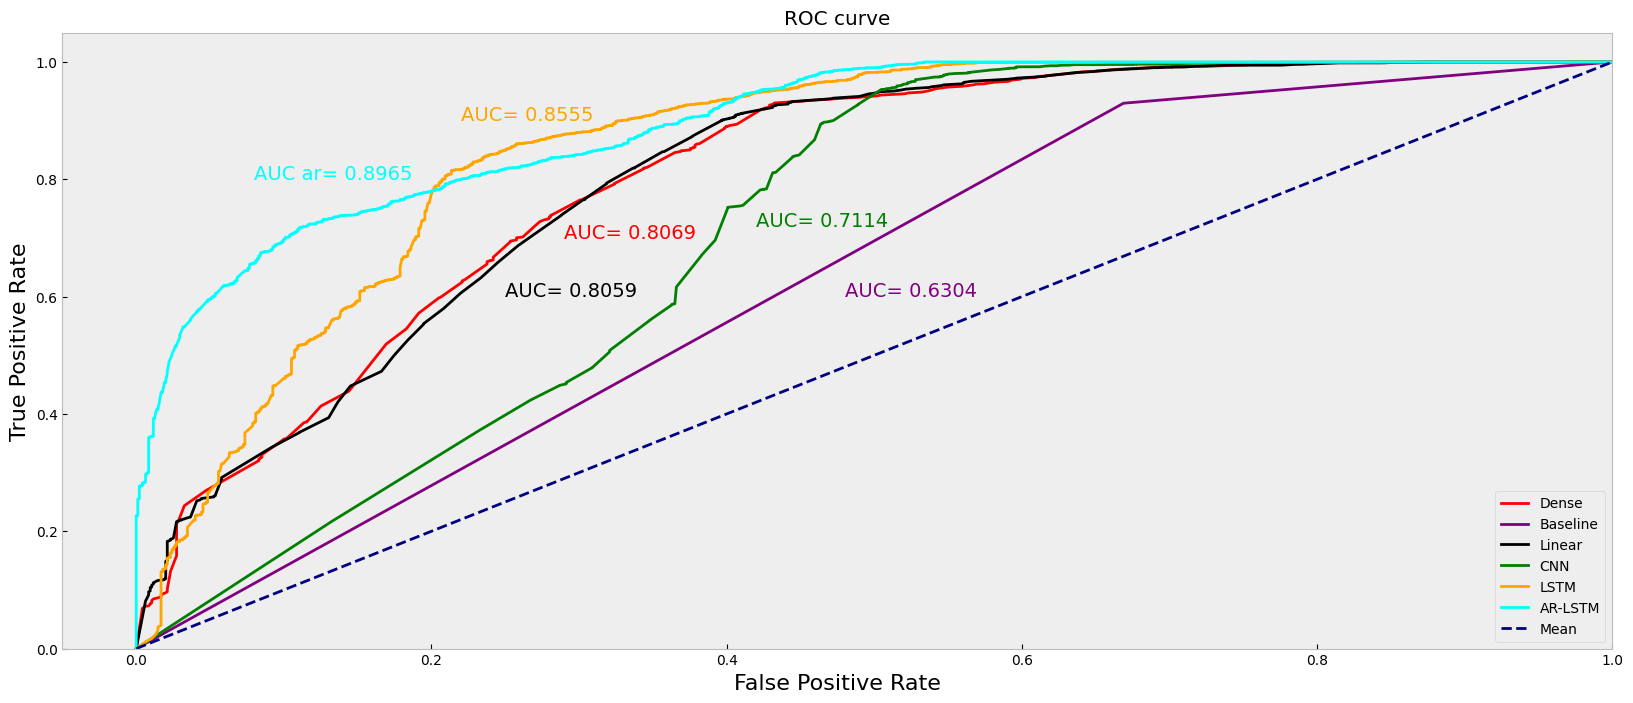

In [ ]:
FPRs_dense, TPRs_dense, _ = roc_curve(y_tests, y_probas_dense)
FPRs_baseline, TPRs_baseline, _ = roc_curve(y_tests, y_probas_baseline)
FPRs_linear, TPRs_linear, _ = roc_curve(y_tests, y_probas_linear)
FPRs_cnn, TPRs_cnn, _ = roc_curve(y_tests, y_probas_cnn)
FPRs_lstm, TPRs_lstm, _ = roc_curve(y_tests, y_probas_lstm)
FPRs_ar_lstm, TPRs_ar_lstm, _ = roc_curve(y_tests, y_probas_ar_lstm)

# ROC-AUC
auc_score_dense = metrics.roc_auc_score(y_tests, y_probas_dense)
auc_score_baseline = metrics.roc_auc_score(y_tests, y_probas_baseline)
auc_score_linear = metrics.roc_auc_score(y_tests, y_probas_linear)
auc_score_cnn = metrics.roc_auc_score(y_tests, y_probas_cnn)
auc_score_lstm = metrics.roc_auc_score(y_tests, y_probas_lstm)
auc_score_ar_lstm = metrics.roc_auc_score(y_tests, y_probas_ar_lstm)

# Plot the ROC curve
plt.plot(FPRs_dense, TPRs_dense, color='red', lw=2, label='Dense')
plt.annotate(f'AUC={auc_score_dense: .4f}', xy=(0.29,0.7), color='red', fontsize=14) # xy is added mannualy
plt.plot(FPRs_baseline, TPRs_baseline, color='purple', lw=2, label='Baseline')
plt.annotate(f'AUC={auc_score_baseline: .4f}', xy=(0.48,0.6), color='purple', fontsize=14)
plt.plot(FPRs_linear, TPRs_linear, color='black', lw=2, label='Linear')
plt.annotate(f'AUC={auc_score_linear: .4f}', xy=(0.25,0.6), fontsize=14)
plt.plot(FPRs_cnn, TPRs_cnn, color='green', lw=2, label='CNN')
plt.annotate(f'AUC={auc_score_cnn: .4f}', xy=(0.42,0.72), color='green', fontsize=14)
plt.plot(FPRs_lstm, TPRs_lstm, color='orange', lw=2, label='LSTM')
plt.annotate(f'AUC={auc_score_lstm: .4f}', xy=(0.22,0.9), color='orange', fontsize=14)
plt.plot(FPRs_ar_lstm, TPRs_ar_lstm, color='cyan', lw=2, label='AR-LSTM')
plt.annotate(f'AUC ar={auc_score_ar_lstm: .4f}', xy=(0.08,0.8), color='cyan', fontsize=14)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

### LSTM AUC Comparison



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

In [ ]:
lstm_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/1_Feature/lstm_model_1Day_1Feature')

#### seq-2-step

Time window definition:

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]

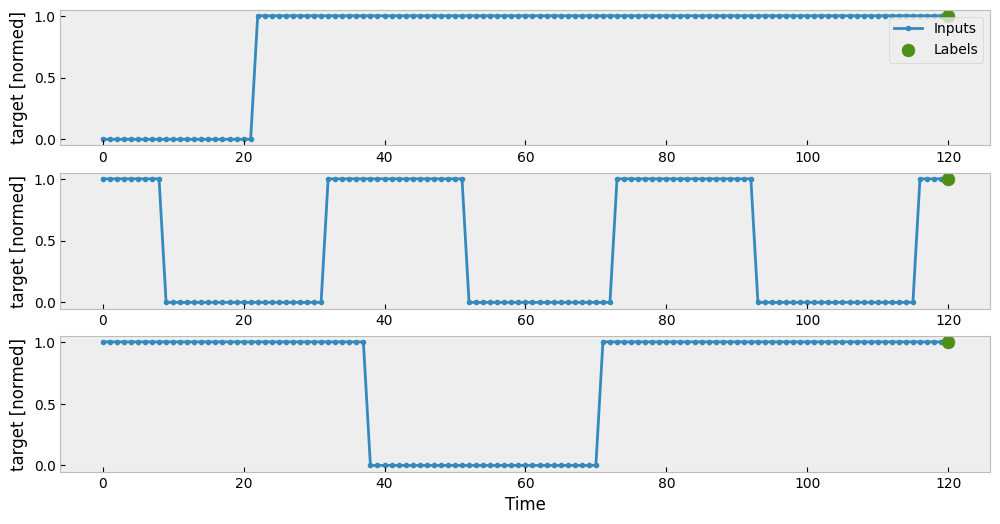

In [ ]:
OUT_STEPS_1 = 1
input_width_1= 120
multi_window_1 = WindowGenerator(input_width=input_width_1,
                               label_width=OUT_STEPS_1,
                               shift=OUT_STEPS_1)
multi_window_1.plot()
multi_window_1

In [ ]:

# initiation
y_tests_1 = []

predictions_lstm_1 = []
y_probas_lstm_1 =[]

i = 0
it = iter(multi_window_1.test)

for i in range(267): #266
        # obtain the next value:
        result = next(it)
        inputs, labels = result
        #batchsize,
        # LSTM-proba (float probability)
        y_proba_lstm = lstm_model_1D.predict(inputs)
        # LSTM-predictions (binary int)
        prediction_lstm = tf.cast(y_proba_lstm > 0.5, tf.int32)

        # M: batch size
        M = inputs.shape[0]
        for j in range(M):
          #batchsize 32,
          y_test = labels[j, 0, multi_window_1.column_indices['target']]
          y_tests_1.append(y_test)
          # -1s- LSTM
          # each time outputs one value
          predictions_lstm_1.append(prediction_lstm[j, 0, multi_window_1.column_indices['target']])
          y_probas_lstm_1.append(y_proba_lstm[j, 0, multi_window_1.column_indices['target']])

# -1s- GCN-LSTM
acc_gcn_lstm_1 = metrics.accuracy_score(y_tests_1, predictions_lstm_1)
ppv_gcn_lstm_1 = metrics.precision_score(y_tests_1, predictions_lstm_1)
tpr_gcn_lstm_1 = metrics.recall_score(y_tests_1, predictions_lstm_1)
f1_gcn_lstm_1 = metrics.f1_score(y_tests_1, predictions_lstm_1)
mcc_gcn_lstm_1 = metrics.matthews_corrcoef(y_tests_1, predictions_lstm_1)
conf_gcn_lstm_1 = metrics.confusion_matrix(y_tests_1, predictions_lstm_1)


print("-1s- LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm_1: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm_1: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm_1: .3f}")
print(f"F1 score:                   {f1_gcn_lstm_1: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm_1: .3f}")
print("confusion matrix: ", conf_gcn_lstm_1)


1/1 [==============================] - 0s 304ms/step
-1s- LSTM Model
Accuracy (ACC):                 0.999
Precision score (PPV):             1.000
Recall score (TPR):              0.999
F1 score:                    1.000
Matthew's correlation coefficient (MCC):   0.996
confusion matrix:  [[ 903    2]
 [   5 7610]]


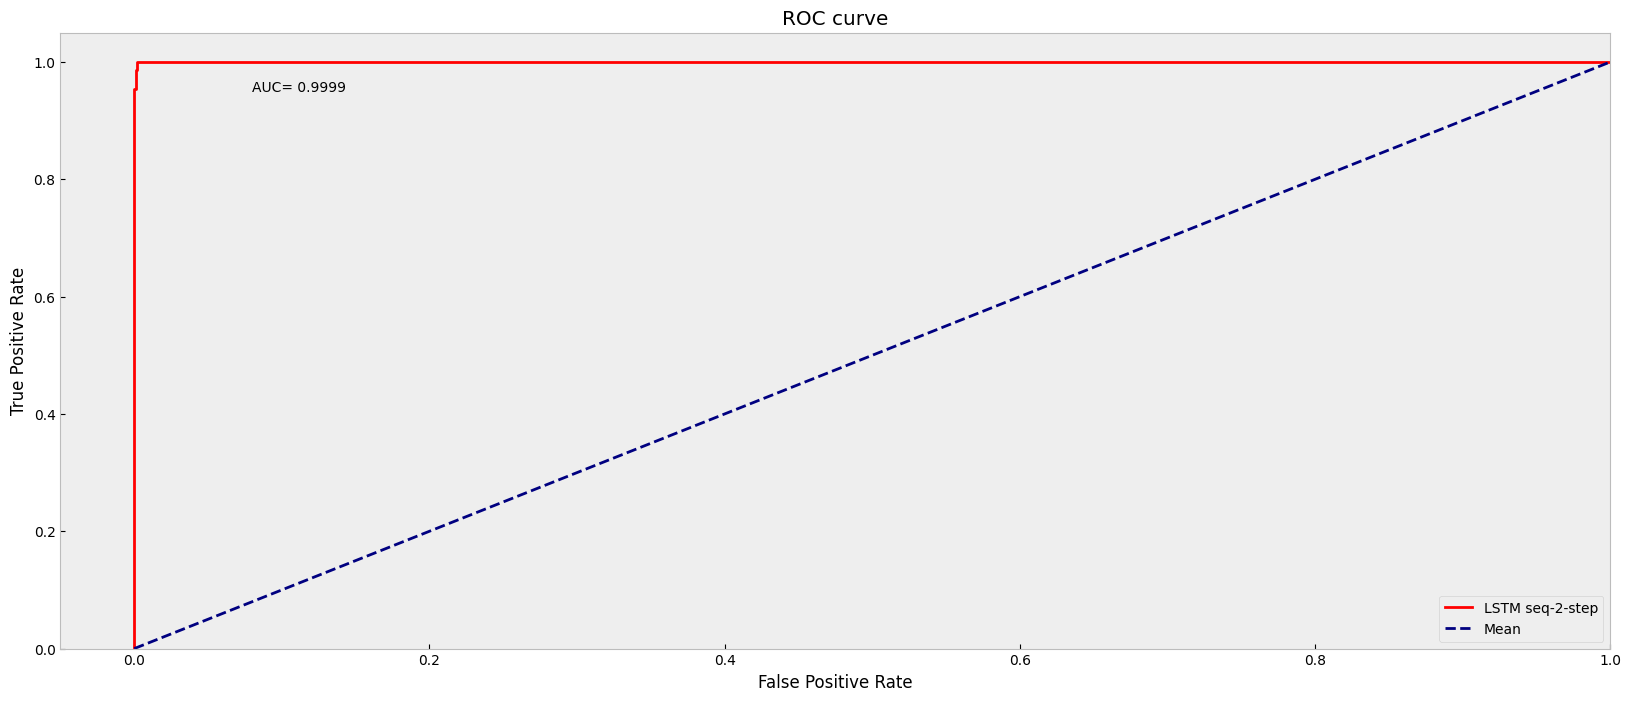

In [ ]:
FPRs_lstm_step, TPRs_lstm_step, _ = roc_curve(y_tests_1, y_probas_lstm_1)
auc_score_lstm_step = metrics.roc_auc_score(y_tests_1, y_probas_lstm_1)

# Plot the ROC curve
plt.plot(FPRs_lstm_step, TPRs_lstm_step, color='red', lw=2, label='LSTM seq-2-step')
plt.annotate(f'AUC={auc_score_lstm_step: .4f}', xy=(0.08,0.95) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### seq-2-seq 15s

Time window definition:

Total window size: 135
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]

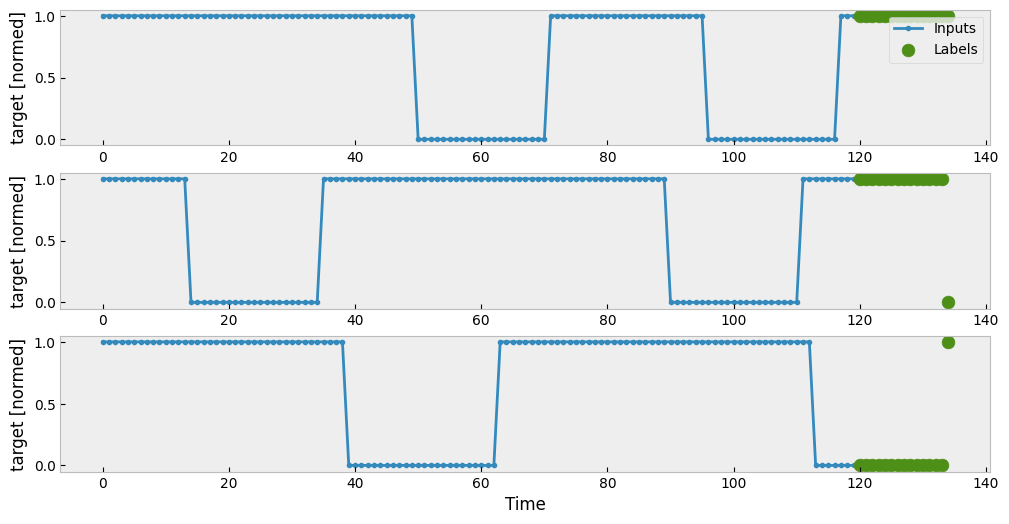

In [ ]:
OUT_STEPS_15 = 15
input_width_15= 120
multi_window_15 = WindowGenerator(input_width=input_width_15,
                               label_width=OUT_STEPS_15,
                               shift=OUT_STEPS_15)

multi_window_15.plot()
multi_window_15

In [ ]:
# initiation
y_tests_15 = []

predictions_lstm_15 = []
y_probas_lstm_15 =[]

i = 0
it = iter(multi_window_15.test)

for i in range(266): #266

        result = next(it)
        inputs, labels = result
        #batchsize,
        y_test = labels[0, :15, multi_window_15.column_indices['target']]
        y_tests_15.extend(y_test)
        # -15s- LSTM
        # LSTM-predictions (binary int)
        prediction_lstm = (lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_lstm_15.extend(prediction_lstm[0, :15, multi_window_15.column_indices['target']])
        # LSTM-proba (float probability)
        y_proba_lstm = lstm_model_1D.predict(inputs)
        y_probas_lstm_15.extend(y_proba_lstm[0, :15, multi_window_15.column_indices['target']])
        # next batch
        y_testnew = labels[1, :15, multi_window_15.column_indices['target']]
        y_tests_15.extend(y_testnew)
        predictions_lstm_15.extend(prediction_lstm[1, :15, multi_window_15.column_indices['target']])
        y_probas_lstm_15.extend(y_proba_lstm[1, :15, multi_window_15.column_indices['target']])

# -15s- LSTM
acc_lstm_15 = metrics.accuracy_score(y_tests_15, predictions_lstm_15)
ppv_lstm_15 = metrics.precision_score(y_tests_15, predictions_lstm_15)
tpr_lstm_15 = metrics.recall_score(y_tests_15, predictions_lstm_15)
f1_lstm_15 = metrics.f1_score(y_tests_15, predictions_lstm_15)
mcc_lstm_15 = metrics.matthews_corrcoef(y_tests_15, predictions_lstm_15)
conf_lstm_15 = metrics.confusion_matrix(y_tests_15, predictions_lstm_15)


print("-15s- LSTM Model")
print(f"Accuracy (ACC):                {acc_lstm_15: .3f}")
print(f"Precision score (PPV):            {ppv_lstm_15: .3f}")
print(f"Recall score (TPR):             {tpr_lstm_15: .3f}")
print(f"F1 score:                   {f1_lstm_15: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_lstm_15: .3f}")
print("confusion matrix: ", conf_lstm_15)


1/1 [==============================] - 0s 32ms/step
-15s- LSTM Model
Accuracy (ACC):                 0.972
Precision score (PPV):             0.978
Recall score (TPR):              0.991
F1 score:                    0.985
Matthew's correlation coefficient (MCC):   0.846
confusion matrix:  [[ 676  157]
 [  64 7083]]


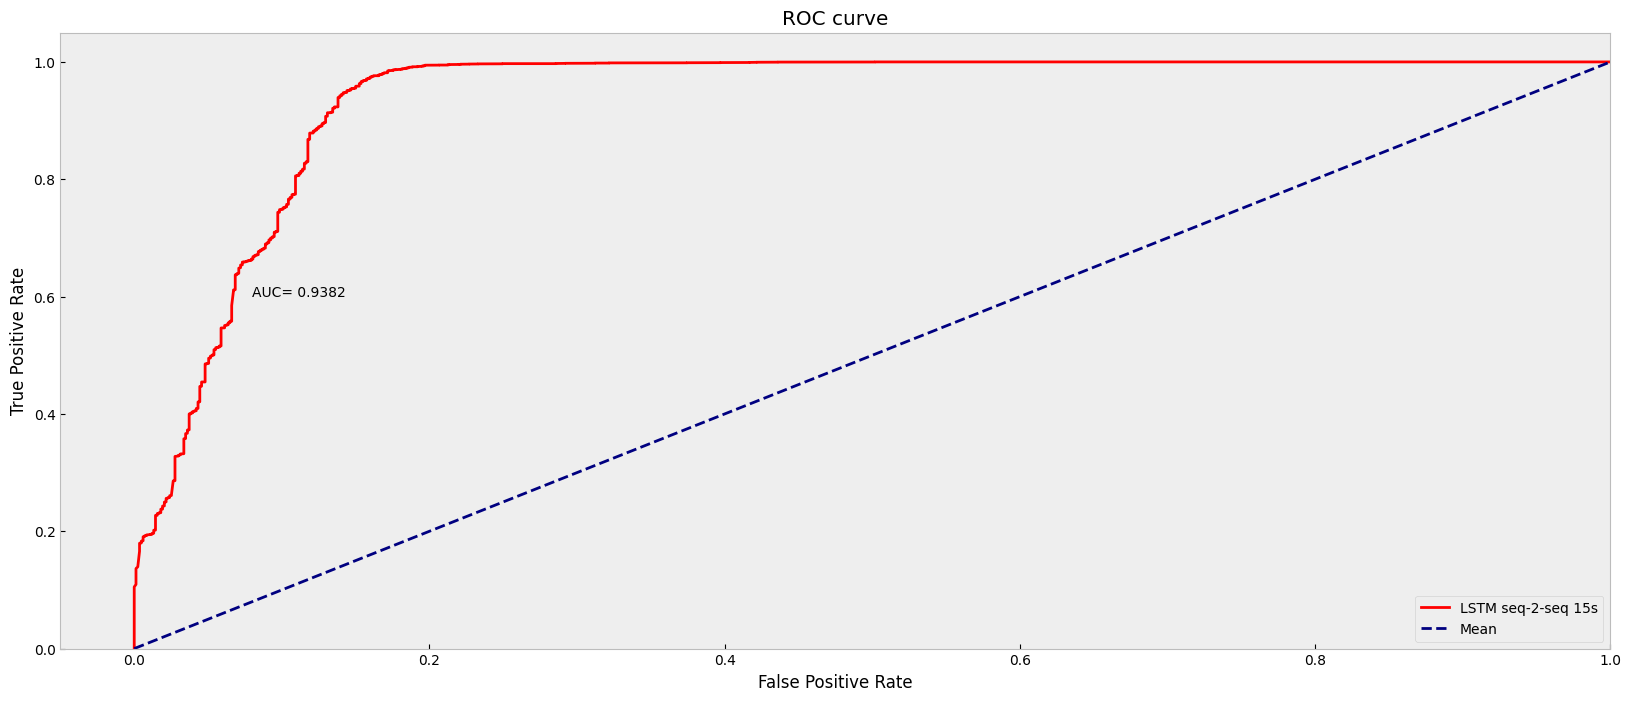

In [ ]:
FPRs_lstm_seq15, TPRs_lstm_seq15, _ = roc_curve(y_tests_15, y_probas_lstm_15)
auc_score_lstm_seq15 = metrics.roc_auc_score(y_tests_15, y_probas_lstm_15)

# Plot the ROC curve
plt.plot(FPRs_lstm_seq15, TPRs_lstm_seq15, color='red', lw=2, label='LSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_lstm_seq15: .4f}', xy=(0.08,0.6) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### seq-2-seq 30s

Time window definition:

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

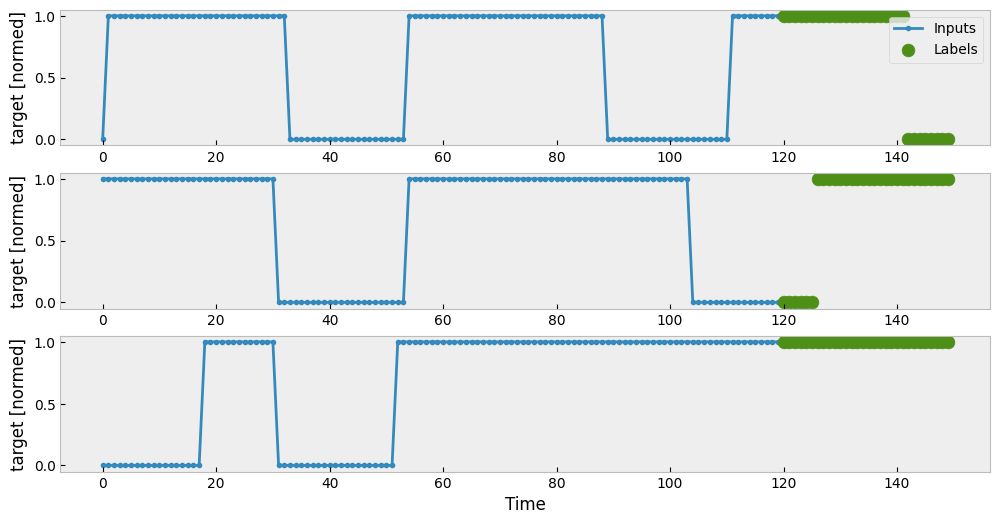

In [ ]:
OUT_STEPS_30 = 30
input_width_30= 120
multi_window_30 = WindowGenerator(input_width=input_width_30,
                               label_width=OUT_STEPS_30,
                               shift=OUT_STEPS_30)

multi_window_30.plot()
multi_window_30

In [ ]:
# initiation
y_tests_30 = []

predictions_lstm_30 = []
y_probas_lstm_30 =[]

i = 0
it = iter(multi_window_30.test)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result
        #第一维参数是 batchsize, 32 和 30相近，只取第一个batch 不会影响整体样本数量，按理说应该遍历每一个batch,0,1,2,...
        y_test = labels[0, :, multi_window_30.column_indices['target']]
        y_tests_30.extend(y_test)
        # -30s- LSTM
        # LSTM-predictions (binary int)
        prediction_lstm = (lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_lstm_30.extend(prediction_lstm[0, :, multi_window_30.column_indices['target']])
        # LSTM-proba (float probability)
        y_proba_lstm = lstm_model_1D.predict(inputs)
        y_probas_lstm_30.extend(y_proba_lstm[0, :, multi_window_30.column_indices['target']])

# -30s- LSTM
acc_lstm_30 = metrics.accuracy_score(y_tests_30, predictions_lstm_30)
ppv_lstm_30 = metrics.precision_score(y_tests_30, predictions_lstm_30)
tpr_lstm_30 = metrics.recall_score(y_tests_30, predictions_lstm_30)
f1_lstm_30 = metrics.f1_score(y_tests_30, predictions_lstm_30)
mcc_lstm_30 = metrics.matthews_corrcoef(y_tests_30, predictions_lstm_30)
conf_lstm_30 = metrics.confusion_matrix(y_tests_30, predictions_lstm_30)


print("-30s- LSTM Model")
print(f"Accuracy (ACC):                {acc_lstm_30: .3f}")
print(f"Precision score (PPV):            {ppv_lstm_30: .3f}")
print(f"Recall score (TPR):             {tpr_lstm_30: .3f}")
print(f"F1 score:                   {f1_lstm_30: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_lstm_30: .3f}")
print("confusion matrix: ", conf_lstm_30)


1/1 [==============================] - 0s 22ms/step
-30s- LSTM Model
Accuracy (ACC):                 0.904
Precision score (PPV):             0.935
Recall score (TPR):              0.958
F1 score:                    0.947
Matthew's correlation coefficient (MCC):   0.497
confusion matrix:  [[ 460  470]
 [ 293 6757]]


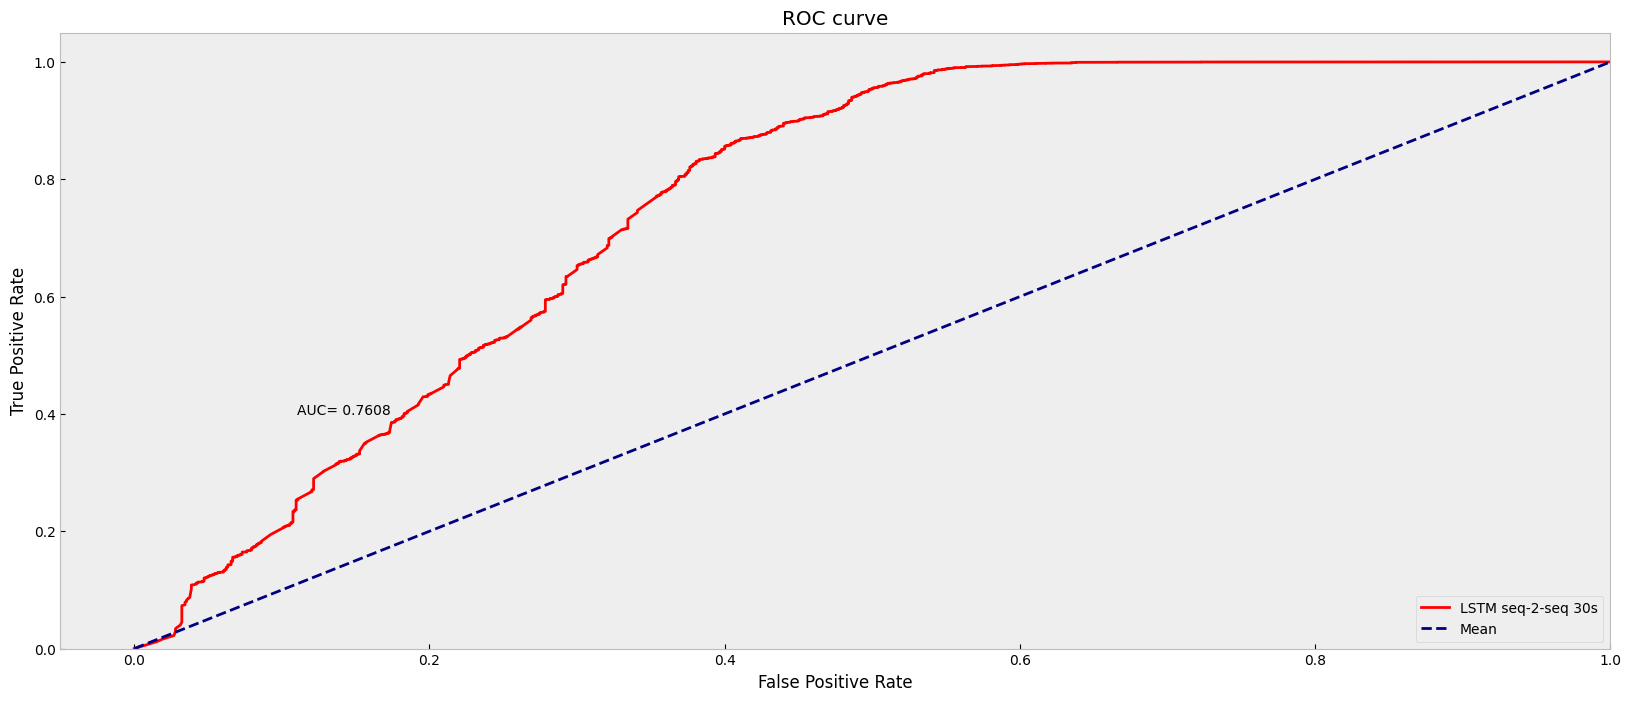

In [ ]:
FPRs_lstm_seq30, TPRs_lstm_seq30, _ = roc_curve(y_tests_30, y_probas_lstm_30)
auc_score_lstm_seq30 = metrics.roc_auc_score(y_tests_30, y_probas_lstm_30)

# Plot the ROC curve
plt.plot(FPRs_lstm_seq30, TPRs_lstm_seq30, color='red', lw=2, label='LSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_lstm_seq30: .4f}', xy=(0.11,0.4) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### AUCs Comparison

Compare three AUCs of seq-2-step, seq-2-seq 15s, and seq-2-seq 30s of LSTM-1D trained by only one feature "K1".

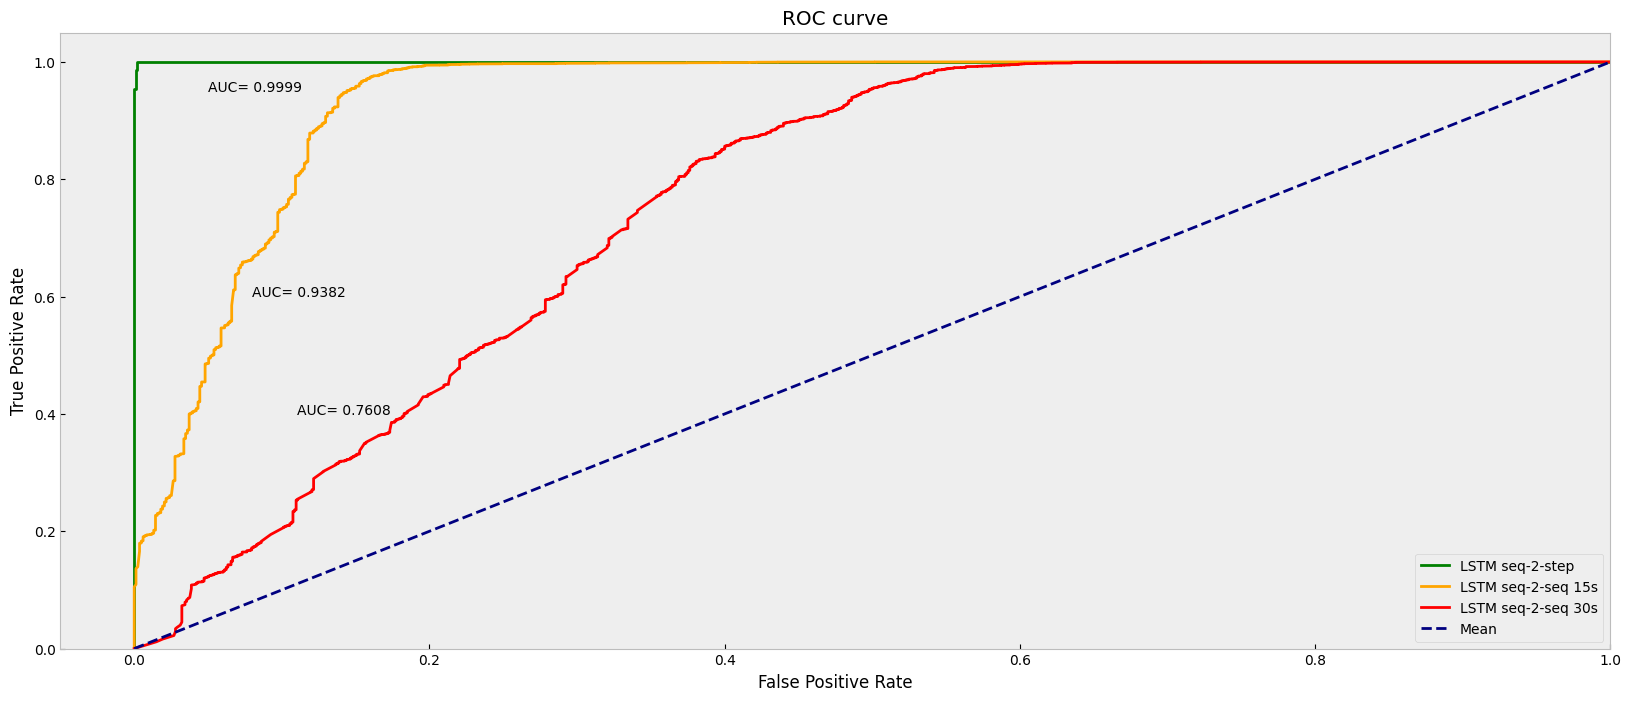

In [ ]:

# Plot the ROC curve
# -1- seq-2-step
plt.plot(FPRs_lstm_step, TPRs_lstm_step, color='green', lw=2, label='LSTM seq-2-step')
plt.annotate(f'AUC={auc_score_lstm_step: .4f}', xy=(0.05,0.95) )

# -2- seq-2-seq 15s
plt.plot(FPRs_lstm_seq15, TPRs_lstm_seq15, color='orange', lw=2, label='LSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_lstm_seq15: .4f}', xy=(0.08,0.6) )


# -3- seq-2-seq 30s
plt.plot(FPRs_lstm_seq30, TPRs_lstm_seq30, color='red', lw=2, label='LSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_lstm_seq30: .4f}', xy=(0.11,0.4) )

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

### AR LSTM 1D AUCs Comparison

Compare three AUCs of AR_LSTM-1D model, for seq-2-step, seq-2-seq 15s, and seq-2-seq 30s.



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

ar_lstm_model_1D = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/ar_lstm_model_1Day_1Feature')

#### seq-2-step

Time window definition:

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]

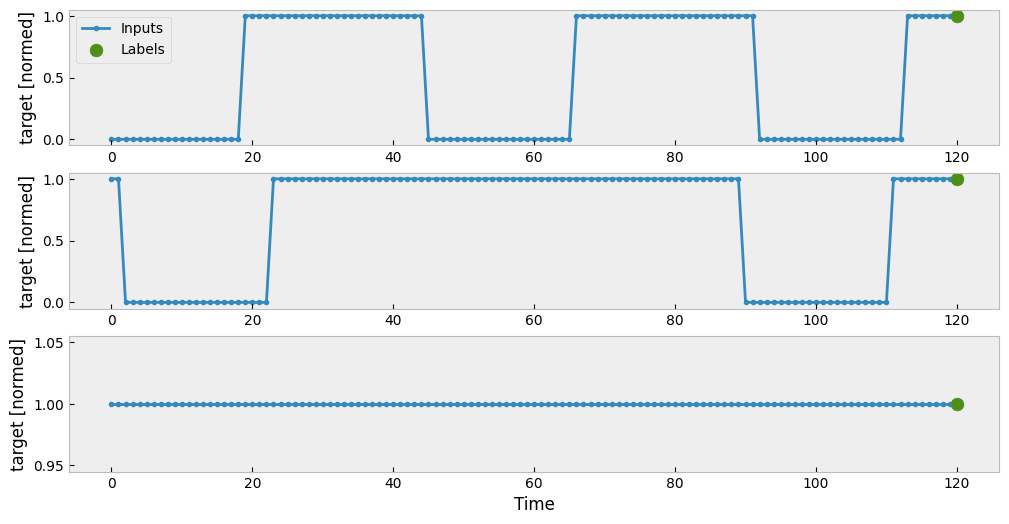

In [ ]:
OUT_STEPS_1_ar = 1
input_width_1_ar= 120
multi_window_1_ar = WindowGenerator(input_width=input_width_1_ar,
                               label_width=OUT_STEPS_1_ar,
                               shift=OUT_STEPS_1_ar)
multi_window_1_ar.plot()
multi_window_1_ar

In [ ]:

# initiation
y_tests_1_ar = []

predictions_arlstm_1 = []
y_probas_arlstm_1 =[]

i = 0
it = iter(multi_window_1_ar.test)

for i in range(267): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result
        #第一维参数是 batchsize, 应该遍历每一个batch,0,1,2,...,每次取第一秒预测值
        # LSTM-proba (float probability)
        y_proba_arlstm = ar_lstm_model_1D.predict(inputs)
        # LSTM-predictions (binary int)
        prediction_arlstm = tf.cast(y_proba_arlstm > 0.5, tf.int32)

        # M: batch size
        M = inputs.shape[0]
        for j in range(M):
          #batchsize 32,
          y_test_ar = labels[j, 0, multi_window_1_ar.column_indices['target']]
          y_tests_1_ar.append(y_test_ar)
          # -1s- LSTM
          # each time outputs one value
          predictions_arlstm_1.append(prediction_arlstm[j, 0, multi_window_1_ar.column_indices['target']])
          y_probas_arlstm_1.append(y_proba_arlstm[j, 0, multi_window_1_ar.column_indices['target']])

# -1s- GCN-LSTM
acc_gcn_arlstm_1 = metrics.accuracy_score(y_tests_1_ar, predictions_arlstm_1)
ppv_gcn_arlstm_1 = metrics.precision_score(y_tests_1_ar, predictions_arlstm_1)
tpr_gcn_arlstm_1 = metrics.recall_score(y_tests_1_ar, predictions_arlstm_1)
f1_gcn_arlstm_1 = metrics.f1_score(y_tests_1_ar, predictions_arlstm_1)
mcc_gcn_arlstm_1 = metrics.matthews_corrcoef(y_tests_1_ar, predictions_arlstm_1)
conf_gcn_arlstm_1 = metrics.confusion_matrix(y_tests_1_ar, predictions_arlstm_1)


print("-1s- AR LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_arlstm_1: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_arlstm_1: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_arlstm_1: .3f}")
print(f"F1 score:                   {f1_gcn_arlstm_1: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_arlstm_1: .3f}")
print("confusion matrix: ", conf_gcn_arlstm_1)


1/1 [==============================] - 1s 729ms/step
-1s- AR LSTM Model
Accuracy (ACC):                 0.997
Precision score (PPV):             0.999
Recall score (TPR):              0.998
F1 score:                    0.999
Matthew's correlation coefficient (MCC):   0.987
confusion matrix:  [[ 901    4]
 [  18 7597]]


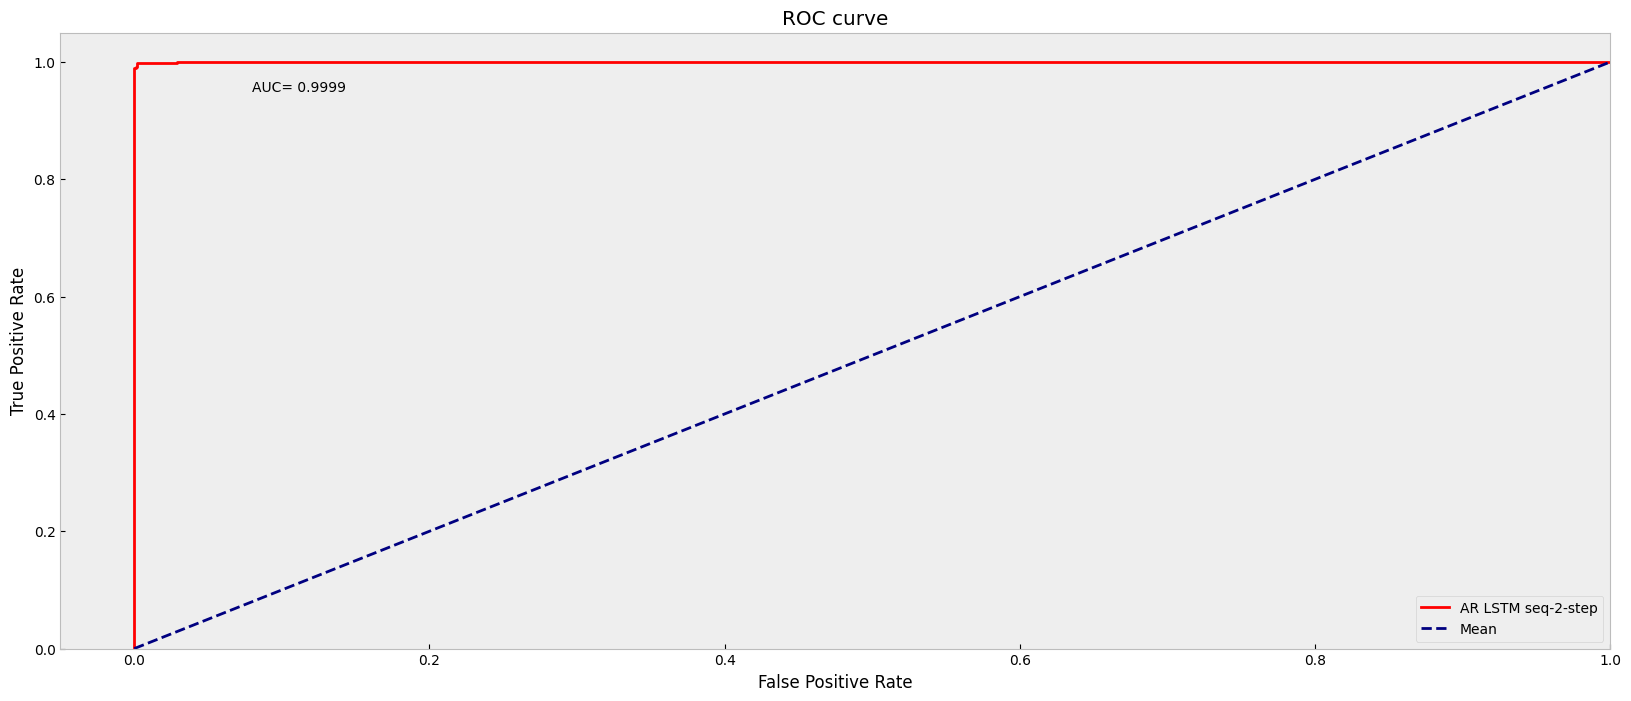

In [ ]:
FPRs_arlstm_step, TPRs_arlstm_step, _ = roc_curve(y_tests_1_ar, y_probas_arlstm_1)
auc_score_arlstm_step = metrics.roc_auc_score(y_tests_1_ar, y_probas_arlstm_1)

# Plot the ROC curve
plt.plot(FPRs_arlstm_step, TPRs_arlstm_step, color='red', lw=2, label='AR LSTM seq-2-step')
plt.annotate(f'AUC={auc_score_arlstm_step: .4f}', xy=(0.08,0.95) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### seq-2-seq 15s

Time window definition:

Total window size: 135
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]

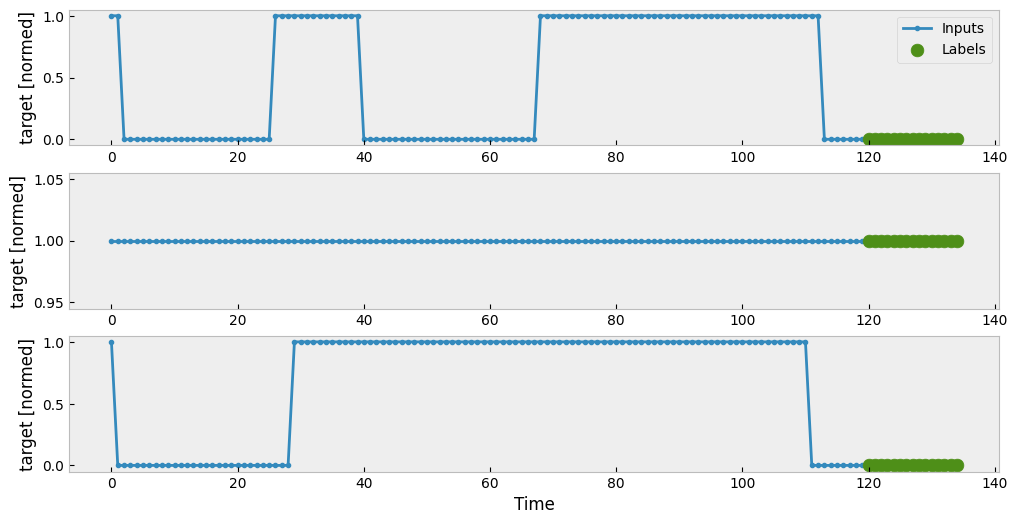

In [ ]:
OUT_STEPS_15_ar = 15
input_width_15_ar= 120
multi_window_15_ar = WindowGenerator(input_width=input_width_15_ar,
                               label_width=OUT_STEPS_15_ar,
                               shift=OUT_STEPS_15_ar)

multi_window_15_ar.plot()
multi_window_15_ar

In [ ]:
# initiation
y_tests_15_ar = []

predictions_arlstm_15 = []
y_probas_arlstm_15 =[]

i = 0
it = iter(multi_window_15_ar.test)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result
        #第一维参数是 batchsize, 每次预测30s, 只取前15s, 需要前两个batch，以求最终比对时，样本数量差不多，按理说应该遍历每一个batch,0,1,2,...
        y_test = labels[0, :15, multi_window_15_ar.column_indices['target']]
        y_tests_15_ar.extend(y_test)
        # -15s- LSTM
        # LSTM-predictions (binary int)
        prediction_arlstm = (ar_lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_arlstm_15.extend(prediction_arlstm[0, :15, multi_window_15_ar.column_indices['target']])
        # LSTM-proba (float probability)
        y_proba_arlstm = ar_lstm_model_1D.predict(inputs)
        y_probas_arlstm_15.extend(y_proba_arlstm[0, :15, multi_window_15_ar.column_indices['target']])
        # next batch
        y_testnew = labels[1, :15, multi_window_15_ar.column_indices['target']]
        y_tests_15_ar.extend(y_testnew)
        predictions_arlstm_15.extend(prediction_arlstm[1, :15, multi_window_15_ar.column_indices['target']])
        y_probas_arlstm_15.extend(y_proba_arlstm[1, :15, multi_window_15_ar.column_indices['target']])

# -15s- LSTM
acc_arlstm_15 = metrics.accuracy_score(y_tests_15_ar, predictions_arlstm_15)
ppv_arlstm_15 = metrics.precision_score(y_tests_15_ar, predictions_arlstm_15)
tpr_arlstm_15 = metrics.recall_score(y_tests_15_ar, predictions_arlstm_15)
f1_arlstm_15 = metrics.f1_score(y_tests_15_ar, predictions_arlstm_15)
mcc_arlstm_15 = metrics.matthews_corrcoef(y_tests_15_ar, predictions_arlstm_15)
conf_arlstm_15 = metrics.confusion_matrix(y_tests_15_ar, predictions_arlstm_15)


print("-15s- AR LSTM Model")
print(f"Accuracy (ACC):                {acc_arlstm_15: .3f}")
print(f"Precision score (PPV):            {ppv_arlstm_15: .3f}")
print(f"Recall score (TPR):             {tpr_arlstm_15: .3f}")
print(f"F1 score:                   {f1_arlstm_15: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_arlstm_15: .3f}")
print("confusion matrix: ", conf_arlstm_15)


1/1 [==============================] - 0s 102ms/step
-15s- AR LSTM Model
Accuracy (ACC):                 0.977
Precision score (PPV):             0.980
Recall score (TPR):              0.995
F1 score:                    0.988
Matthew's correlation coefficient (MCC):   0.860
confusion matrix:  [[ 603  148]
 [  34 7195]]


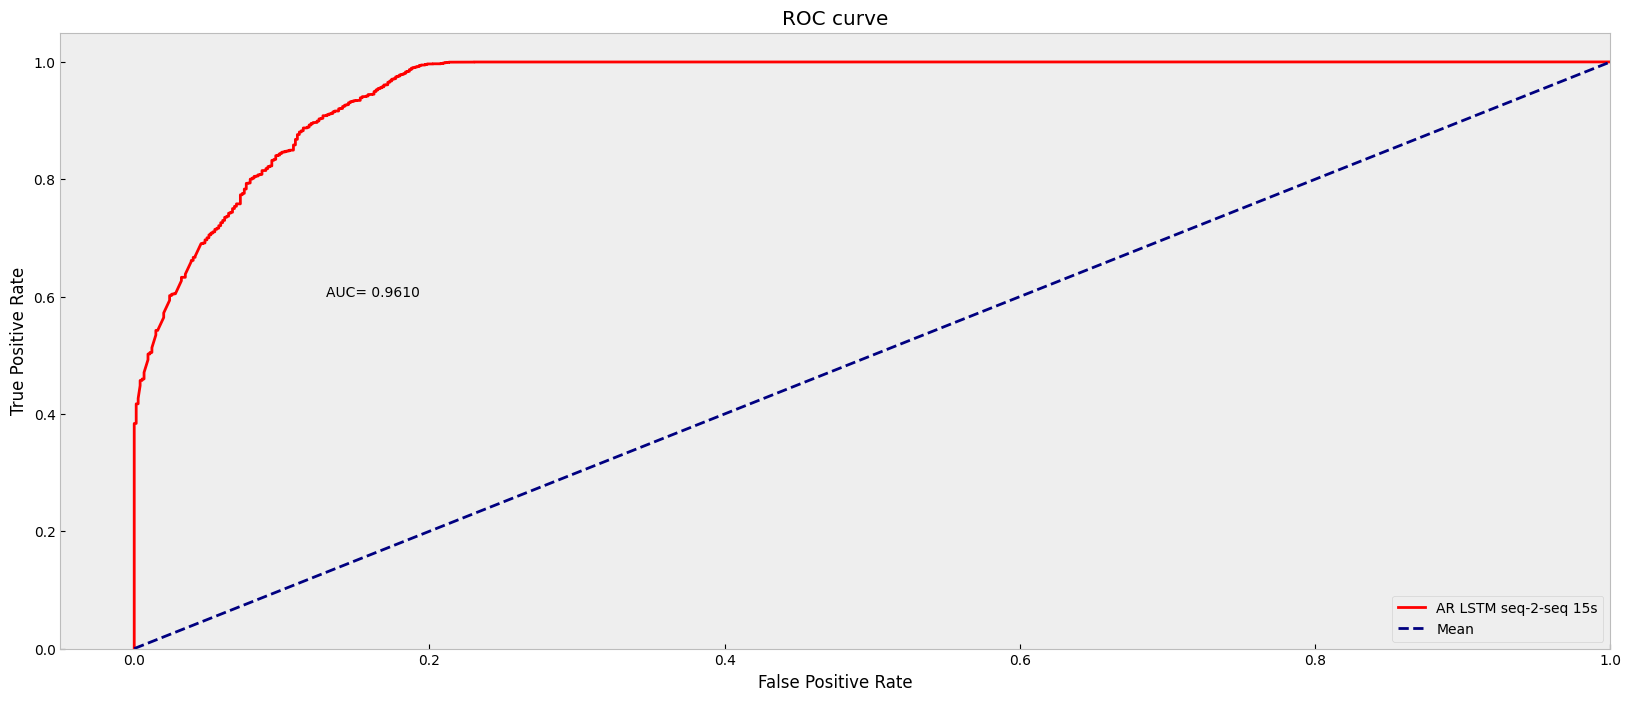

In [ ]:
FPRs_arlstm_seq15, TPRs_arlstm_seq15, _ = roc_curve(y_tests_15_ar, y_probas_arlstm_15)
auc_score_arlstm_seq15 = metrics.roc_auc_score(y_tests_15_ar, y_probas_arlstm_15)

# Plot the ROC curve
plt.plot(FPRs_arlstm_seq15, TPRs_arlstm_seq15, color='red', lw=2, label='AR LSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_arlstm_seq15: .4f}', xy=(0.13,0.6) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### seq-2-seq 30s

Time window definition:

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

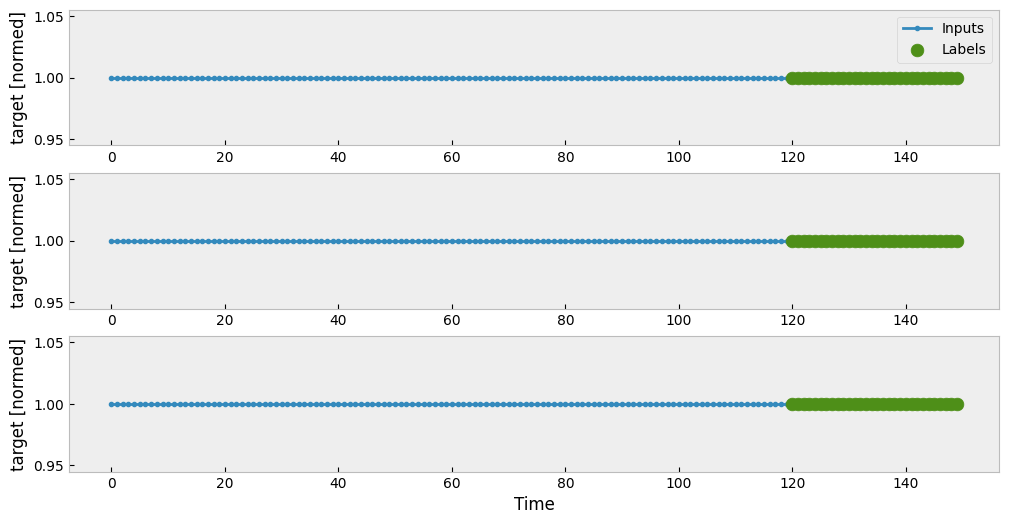

In [ ]:
OUT_STEPS_30_ar = 30
input_width_30_ar= 120
multi_window_30_ar = WindowGenerator(input_width=input_width_30_ar,
                               label_width=OUT_STEPS_30_ar,
                               shift=OUT_STEPS_30_ar)

multi_window_30_ar.plot()
multi_window_30_ar

In [ ]:
# initiation
y_tests_30_ar = []

predictions_arlstm_30 = []
y_probas_arlstm_30 =[]

i = 0
it = iter(multi_window_30_ar.test)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result
        #第一维参数是 batchsize, 32 和 30相近，只取第一个batch 不会影响整体样本数量，按理说应该遍历每一个batch,0,1,2,...
        y_test = labels[0, :, multi_window_30_ar.column_indices['target']]
        y_tests_30_ar.extend(y_test)
        # -30s- LSTM
        # LSTM-predictions (binary int)
        prediction_arlstm = (ar_lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_arlstm_30.extend(prediction_arlstm[0, :, multi_window_30_ar.column_indices['target']])
        # LSTM-proba (float probability)
        y_proba_arlstm = ar_lstm_model_1D.predict(inputs)
        y_probas_arlstm_30.extend(y_proba_arlstm[0, :, multi_window_30_ar.column_indices['target']])

# -30s- LSTM
acc_arlstm_30 = metrics.accuracy_score(y_tests_30_ar, predictions_arlstm_30)
ppv_arlstm_30 = metrics.precision_score(y_tests_30_ar, predictions_arlstm_30)
tpr_arlstm_30 = metrics.recall_score(y_tests_30_ar, predictions_arlstm_30)
f1_arlstm_30 = metrics.f1_score(y_tests_30_ar, predictions_arlstm_30)
mcc_arlstm_30 = metrics.matthews_corrcoef(y_tests_30_ar, predictions_arlstm_30)
conf_arlstm_30 = metrics.confusion_matrix(y_tests_30_ar, predictions_arlstm_30)


print("-30s- AR LSTM Model")
print(f"Accuracy (ACC):                {acc_arlstm_30: .3f}")
print(f"Precision score (PPV):            {ppv_arlstm_30: .3f}")
print(f"Recall score (TPR):             {tpr_arlstm_30: .3f}")
print(f"F1 score:                   {f1_arlstm_30: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_arlstm_30: .3f}")
print("confusion matrix: ", conf_arlstm_30)


1/1 [==============================] - 0s 59ms/step
-30s- AR LSTM Model
Accuracy (ACC):                 0.901
Precision score (PPV):             0.934
Recall score (TPR):              0.956
F1 score:                    0.945
Matthew's correlation coefficient (MCC):   0.430
confusion matrix:  [[ 367  480]
 [ 312 6821]]


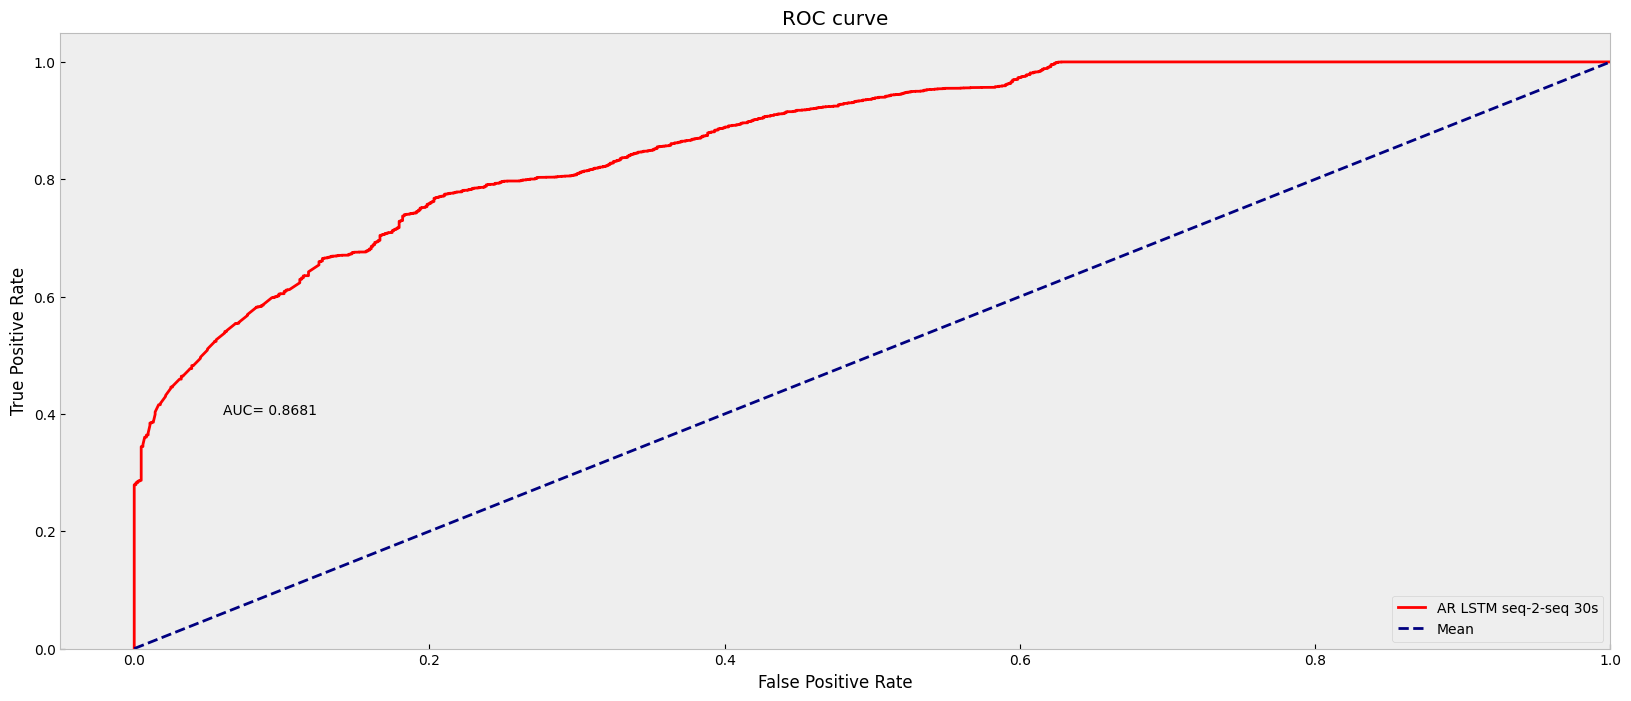

In [ ]:
FPRs_arlstm_seq30, TPRs_arlstm_seq30, _ = roc_curve(y_tests_30_ar, y_probas_arlstm_30)
auc_score_arlstm_seq30 = metrics.roc_auc_score(y_tests_30_ar, y_probas_arlstm_30)

# Plot the ROC curve
plt.plot(FPRs_arlstm_seq30, TPRs_arlstm_seq30, color='red', lw=2, label='AR LSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_arlstm_seq30: .4f}', xy=(0.06,0.4) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### AUCs Comparison

Compare three AUCs of seq-2-step, seq-2-seq 15s, and seq-2-seq 30s of AR LSTM-1D trained by only one feature "K1".

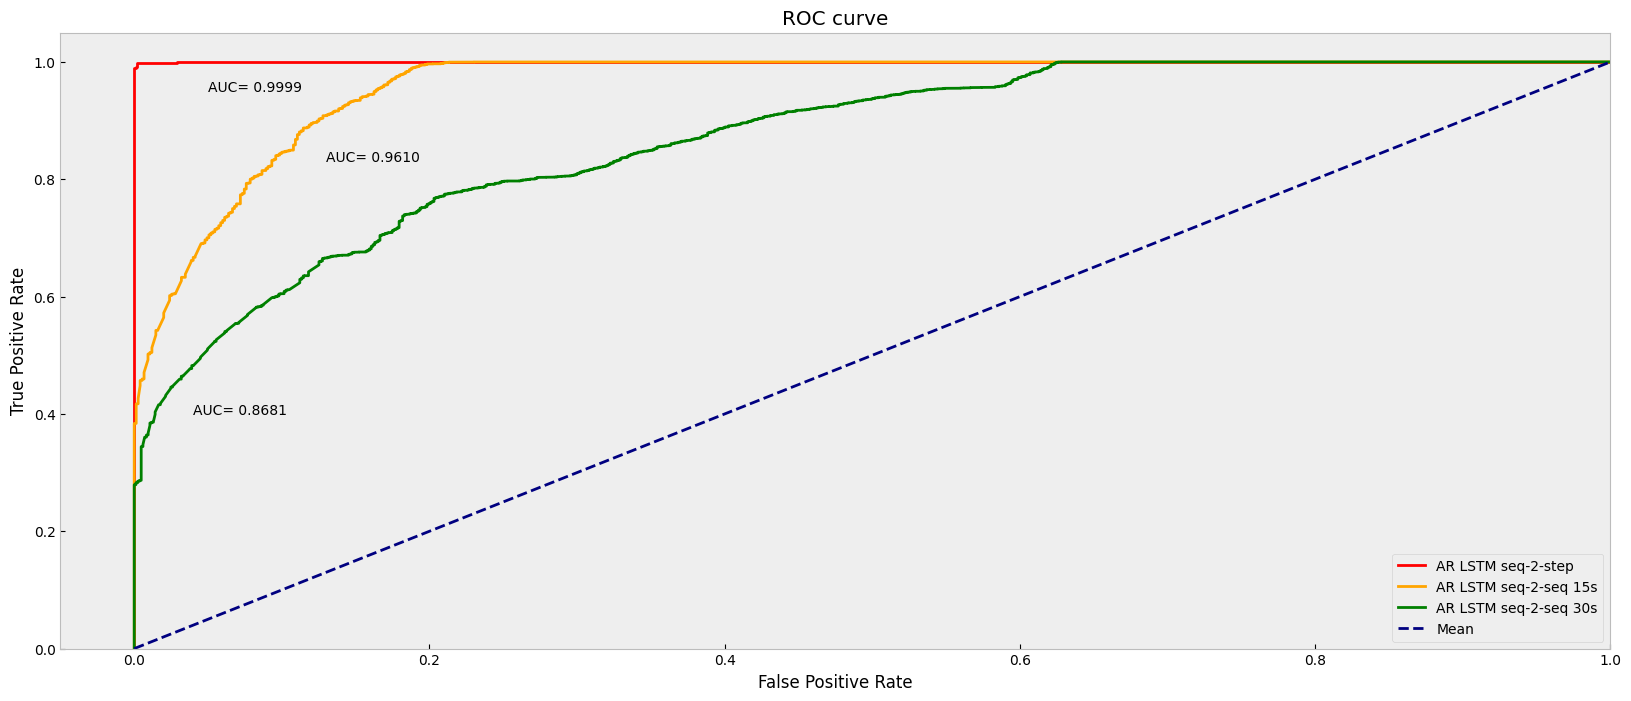

In [ ]:

# Plot the ROC curve
# -1- seq-2-step
plt.plot(FPRs_arlstm_step, TPRs_arlstm_step, color='red', lw=2, label='AR LSTM seq-2-step')
plt.annotate(f'AUC={auc_score_arlstm_step: .4f}', xy=(0.05,0.95) )

# -2- seq-2-seq 15s
plt.plot(FPRs_arlstm_seq15, TPRs_arlstm_seq15, color='orange', lw=2, label='AR LSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_arlstm_seq15: .4f}', xy=(0.13,0.83) )


# -3- seq-2-seq 30s
plt.plot(FPRs_arlstm_seq30, TPRs_arlstm_seq30, color='green', lw=2, label='AR LSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_arlstm_seq30: .4f}', xy=(0.04,0.4) )

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()